# Ablation: Semi-Supervised Architope - for Reviews
---
- This code Implements Algorithm 3.2 of the "PC-NNs" paper.

#### Mode: Code-Testin Parameter(s)

In [1]:
trial_run = True

### Meta-parameters

In [2]:
# Test-size Ratio
test_size_ratio = 1-(1/24)
min_width = 50
# Ablation Finess
N_plot_finess = 4
# min_parts_threshold = .001; max_parts_threshold = 0.9
N_min_parts = 1; N_max_plots = 10
Tied_Neurons_Q = True

In [3]:
#------------------------------------#
# Only For Motivational Example Only #
#------------------------------------#
## Hyperparameters
percentage_in_row = .25
N = 10**3

def f_1(x):
    return x
def f_2(x):
    return 1 + np.exp(x)
x_0 = 0
x_end = 1
import seaborn as sns

### Hyperparameters

Only turn of if running code directly here, typically this script should be run be called by other notebooks.  

In [4]:
# load dataset
results_path = "./outputs/models/"
results_tables_path = "./outputs/results/"
raw_data_path_folder = "./inputs/raw/"
data_path_folder = "./inputs/data/"

### Import

Using TensorFlow backend.


Deep Feature Builder - Ready
Deep Classifier - Ready
1
Training Data size:  41


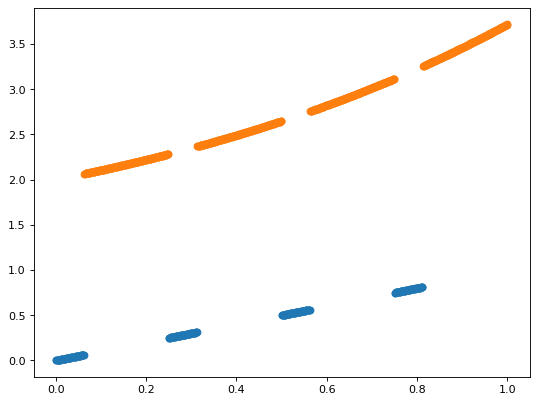

In [5]:
# Load Packages/Modules
exec(open('Init_Dump.py').read())
# Load Hyper-parameter Grid
exec(open('Grid_Enhanced_Network.py').read())
# Load Helper Function(s)
exec(open('Helper_Functions.py').read())
# Pre-process Data
if Option_Function != "Motivational_Example": 
    exec(open('Financial_Data_Preprocessor.py').read())
else:
    print(1)
    exec(open('Motivational_Example.py').read())
    print("Training Data size: ",X_train.shape[0])
# Import time separately
import time

# TEMP
# import pickle_compat
# pickle_compat.patch()
# param_grid_Vanilla_Nets['input_dim']=X_train.shape[1]
plt.show()

### Set Seed

In [6]:
random.seed(2021)
tf.random.set_seed(2021)

#### Pre-Process:
- Convert Categorical Variables to Dummies
- Remove Bad Column
- Perform Training/Test Split

# Random Lipschitz Partition Builder

We implement the random paritioning method of [Yair Bartal](https://scholar.google.com/citations?user=eCXP24kAAAAJ&hl=en):
- [On approximating arbitrary metrices by tree metrics](https://dl.acm.org/doi/10.1145/276698.276725)

The algorithm is summarized as follow:

---

## Algorithm:
 1. Sample $\alpha \in [4^{-1},2^{-1}]$ randomly and uniformly,
 2. Apply a random suffle of the data, (a random bijection $\pi:\{i\}_{i=1}^X \rightarrow \mathbb{X}$),
 3. For $i = 1,\dots,I$:
   - Set $K_i\triangleq B\left(\pi(i),\alpha \Delta \right) - \bigcup_{j=1}^{i-1} P_j$
 
 4. Remove empty members of $\left\{K_i\right\}_{i=1}^X$.  
 
 **Return**: $\left\{K_i\right\}_{i=1}^{\tilde{X}}$.  
 
 For more details on the random-Lipschitz partition of Yair Bartal, see this [well-written blog post](https://nickhar.wordpress.com/2012/03/26/lecture-22-random-partitions-of-metric-spaces/).

## Define Random Partition Builder

#### Explicit Partion Builder:
Implements exactly Algorithm 2:

In [7]:
def Random_Lipschitz_Partioner(X_in,
                               y_in,
                               N_parts_to_get=4):

    # Compute Size of each part
    size_part_reference = int(round(X_in.shape[0]/N_parts_to_get))

    # Apply random bijection #
    #------------------------#
    ## Get random bijection indices
    random_bijection_indices = np.random.choice(range(X_in.shape[0]),size=X_in.shape[0], replace=False)
    ## Apply random bijections
    X_in_shuffled = X_in[random_bijection_indices,:]
    y_in_shuffled = y_in[random_bijection_indices,:]

    # Initialize Lists #
    #------------------#
    X_parts = []
    y_parts = []

    for i_th_part_to_get in range(N_parts_to_get):
        # Build random balls #
        #--------------------#
        ## Sample random radius
        size_part = int(np.maximum(1,np.round(size_part_reference*np.random.uniform(low=.5,high=1.5,size=1)[0])))
        ## Sample random point
        X_center_loop_index = np.random.choice(range(X_in_shuffled.shape[0]),size=1, replace=False)
        X_center_loop = X_in_shuffled[X_center_loop_index,:]
        ## Compute Typical Distances from Center
        distances_loop = X_center_loop-X_in_shuffled
        distances_loop = np.linalg.norm(distances_loop, axis=1)

        # Remove Random Ball from Dataset
        if size_part <= len(distances_loop):
            ## Identify indices
            indices_smallest_to_random_ball = np.argsort(distances_loop)[:size_part]
        else:
            print('Final Loop')
            indices_smallest_to_random_ball = np.array(range(X_in_shuffled.shape[0]))
        ## Extract Parts
        X_current_part_loop = X_in_shuffled[indices_smallest_to_random_ball,:]
        y_current_part_loop = y_in_shuffled[indices_smallest_to_random_ball,:]
        ## Append to List of Parts
        X_parts.append(X_current_part_loop)
        y_parts.append(y_current_part_loop)

        # Remove Selected Entries From Array #
        #------------------------------------#
        X_in_shuffled = np.delete(X_in_shuffled,indices_smallest_to_random_ball,axis=0)
        y_in_shuffled = np.delete(y_in_shuffled,indices_smallest_to_random_ball,axis=0)

        # Failsafe if procedure has terminated
        if X_in_shuffled.shape[0] == 0:
            print('breaking early')
            break
    # Count Number of Parts Generated        
    N_parts_generated = len(X_parts)
    # Output Parts
    return X_parts, y_parts, N_parts_generated

# Ablation Function

In [8]:
def get_PCNNs(N_parts,X_train,y_train,X_test,y_test):

    # Initialization(s) #
    #-------------------#
    N_neurons = 0
    L_timer = 0
    P_timer = 0
    Mean_Width_Subnetworks = 0

    # Partitioner Begin #
    #-------------------#
    import time
    partitioning_time_begin = time.time()
    print('-------------------------------------------------------')
    print('Randomly Initialized Parts - Via Randomized Algorithm 2')
    print('-------------------------------------------------------')
    X_parts_list, y_parts_list, N_parts_Generated_by_Algo_2 = Random_Lipschitz_Partioner(X_train.to_numpy(),
                                                                                         y_train.reshape(-1,1),
                                                                                         N_parts)
    partitioning_time = time.time() - partitioning_time_begin
    print('The_parts_listhe number of parts are: ' + str(N_parts_Generated_by_Algo_2)+'.')
    ############# Partitioner End ########

    print('-----------------------------------------------------')
    print('Training Sub-Networks on Each Randomly Generated Part')
    print('-----------------------------------------------------')
    # Time-Elapse (Start) for Training on Each Part #
    PCNN_timer = time.time(); PCNN_timer = -math.inf; N_params_Architope = 0; N_params_tally = 0
    # Remove Eager Execution Error(s)
    tf.compat.v1.disable_eager_execution()
    # Automatically Initialize Correct Input/Output Dimension(s)
    param_grid_Vanilla_Nets['input_dim'] = [X_train.shape[1]]; param_grid_Vanilla_Nets['output_dim'] = [1]
    param_grid_Deep_Classifier['input_dim'] = [X_train.shape[1]]
    # Decide if/or not to tie neuron numbers of sub-patterns together
    if Tied_Neurons_Q == True:
        param_grid_Vanilla_Nets['height'] = [int(np.maximum(round(param_grid_Vanilla_Nets['height'][0]/N_parts),min_width))]
        param_grid_Deep_Classifier['height'] = [int(np.maximum(round(param_grid_Deep_Classifier['height'][0]/N_parts),min_width))]

    for current_part in range(N_parts_Generated_by_Algo_2):
        # Update User #
        #-------------#
        print('-----------------------------------------------------------')
        print('Currently Training Part: '+str(current_part)+'/'+str(N_parts_Generated_by_Algo_2 )+'Total Parts.')
        print('-----------------------------------------------------------')

        # Timer for Part
        part_training_timer = time.time()
        # Get Data for Sub-Pattern
        X_loop = pd.DataFrame(X_parts_list[current_part])
        y_loop = (y_parts_list[current_part]).reshape(-1,)
        # Train ffNN
        y_hat_part_loop, y_hat_part_loop_test, N_neurons_PCNN_loop = build_ffNN(n_folds = 4, 
                                                                              n_jobs = n_jobs,
                                                                              n_iter = n_iter, 
                                                                              param_grid_in = param_grid_Vanilla_Nets, 
                                                                              X_train= X_loop, 
                                                                              y_train=y_loop,
                                                                              X_test_partial=X_train,
                                                                              X_test=X_test,
                                                                              NOCV=True)
        # Reshape y
        ## Training
        y_train.shape = (y_train.shape[0], param_grid_Vanilla_Nets['output_dim'][0])
        y_hat_part_loop.shape = (y_hat_part_loop.shape[0], param_grid_Vanilla_Nets['output_dim'][0])
        ## Testing
        y_test.shape = (y_test.shape[0], param_grid_Vanilla_Nets['output_dim'][0])
        y_hat_part_loop_test.shape = (y_hat_part_loop_test.shape[0], param_grid_Vanilla_Nets['output_dim'][0])

        # Append predictions to data-frames
        ## If first prediction we initialize data-frames
        if current_part==0:
            # Register quality
            training_quality = np.array(np.abs(y_hat_part_loop-y_train)).reshape(y_hat_part_loop.shape[0],1)

            # Save Predictions
            predictions_train = y_hat_part_loop.reshape(y_hat_part_loop.shape[0],1)
            predictions_test = y_hat_part_loop_test.reshape(y_hat_part_loop_test.shape[0],1)


        ## If not first prediction we append to already initialized dataframes
        else:
        # Register Best Scores
            #----------------------#
            # Write Predictions 
            # Save Predictions
            y_hat_train_loop = y_hat_part_loop.reshape(predictions_train.shape[0],1)
            predictions_train = np.append(predictions_train,y_hat_train_loop,axis=1)
            y_hat_test_loop = y_hat_part_loop_test.reshape(predictions_test.shape[0],1)
            predictions_test = np.append(predictions_test,y_hat_test_loop,axis=1)

            # Evaluate Errors #
            #-----------------#
            # Training
            prediction_errors = np.abs(y_hat_train_loop-y_train)
            training_quality = np.append(training_quality,prediction_errors.reshape(training_quality.shape[0],1),axis=1)

        #==============================#
        # Update Performance Metric(s) #
        #==============================#
        part_training_timer = time.time() - part_training_timer
        # L-Time
        L_timer += partitioning_time
        # P-Time
        P_timer = max(P_timer,part_training_timer)
        # N. Params
        N_neurons += N_neurons_PCNN_loop
        # Mean Width for Sub-Network(s)
        Mean_Width_Subnetworks += param_grid_Vanilla_Nets['height'][0]

    # Take Mean of Width(s)
    Mean_Width_Subnetworks = Mean_Width_Subnetworks/N_parts_Generated_by_Algo_2
    print('-----------------------')
    print('Training Deep Zero-Sets')
    print('-----------------------')


    # Time Elapsed for Training Deep Zero-Sets
    Deep_Zero_Sets_timer = time.time()

    ## Initialize Classes Labels
    partition_labels_training_integers = np.argmin(training_quality,axis=-1)
    partition_labels_training = pd.DataFrame(pd.DataFrame(partition_labels_training_integers) == 0)
    ## Build Classes
    for part_column_i in range(1,(training_quality.shape[1])):
        partition_labels_training = pd.concat([partition_labels_training,
                                               (pd.DataFrame(partition_labels_training_integers) == part_column_i)
                                              ],axis=1)
    ## Convert to integers
    partition_labels_training = partition_labels_training+0
    ## Train simple deep classifier
    tf.compat.v1.disable_eager_execution()
    predicted_classes_train, predicted_classes_test, N_params_deep_classifier = build_simple_deep_classifier(n_folds = CV_folds, 
                                                                                                        n_jobs = n_jobs, 
                                                                                                        n_iter =n_iter, 
                                                                                                        param_grid_in=param_grid_Deep_Classifier, 
                                                                                                        X_train = X_train.values, 
                                                                                                        y_train = partition_labels_training.values,
                                                                                                        X_test = X_test.values)
    # Get Binary Classes (Discontinuous Unit)
    ## Training Set
    predicted_classes_train = ((predicted_classes_train>.5)*1).astype(int)
    ## Testing Set
    predicted_classes_test = ((predicted_classes_test > .5)*1).astype(int)
    # Get PC-NN Prediction(s)
    ## Train
    PCNN_prediction_y_train = (predictions_train*predicted_classes_train).sum(axis=1)
    ## Test
    PCNN_prediction_y_test = (predictions_test*predicted_classes_test).sum(axis=1)

    # End Timer
    Deep_Zero_Sets_timer = time.time() - Deep_Zero_Sets_timer

    print('-----------------------------------')
    print('Computing Final Performance Metrics')
    print('-----------------------------------')
    # Time-Elapsed Training Deep Classifier

    # Update Times
    L_timer +=Deep_Zero_Sets_timer
    P_timer +=Deep_Zero_Sets_timer
    # Update Number of Neurons Used
    N_neurons_subPatterns = N_neurons
    N_neurons_deep_Zero_Sets = (param_grid_Deep_Classifier['height'][0])*(param_grid_Deep_Classifier['depth'][0])
    N_neurons = N_neurons_deep_Zero_Sets + N_neurons_subPatterns



    # Compute Peformance
    performance_PCNN = reporter(y_train_hat_in=PCNN_prediction_y_train,y_test_hat_in=PCNN_prediction_y_test,
                                y_train_in=y_train,
                                y_test_in=y_test)
    # Write Performance
    performance_PCNN.to_latex((results_tables_path+"PCNN_full_performance.tex"))

    # Update User
    print(performance_PCNN)

    ### Model Complexity/Efficiency Metrics
    # Build AIC-like Metric #
    #-----------------------#
    AIC_like = 2*(N_neurons - np.log((performance_PCNN['test']['MAE'])))
    AIC_like = np.round(AIC_like,3)
    Efficiency = np.log(N_neurons) *(performance_PCNN['test']['MAE'])
    Efficiency = np.round(Efficiency,3)


    # Build Table #
    #-------------#
    PCNN_Model_Complexity = pd.DataFrame({'L-time': [L_timer],
                                               'P-time':[P_timer],
                                               'N_params_expt': [N_neurons],
                                               'AIC-like': [AIC_like],
                                               'Eff': [Efficiency],
                                               'N. Parts':[N_parts_Generated_by_Algo_2]})


    # Write Required Training Time(s)
    PCNN_Model_Complexity.to_latex((results_tables_path+"PCNN_full_model_complexities.tex"))

    #--------------======---------------#
    # Display Required Training Time(s) #
    #--------------======---------------#
    print(PCNN_Model_Complexity)
    
    
    # Return Output(s)
    return performance_PCNN, PCNN_Model_Complexity, N_parts_Generated_by_Algo_2, N_neurons, N_neurons_subPatterns,N_neurons_deep_Zero_Sets, Mean_Width_Subnetworks

---
# Perform Ablation:
---

In [ ]:
# Initialize 
# q_implicit_N_parts_possibilities = np.linspace(min_parts_threshold,max_parts_threshold,N_plot_finess)
N_parts_possibilities = np.unique(np.round(np.linspace(N_min_parts,N_max_plots,num=N_plot_finess))).astype(int)

# Get Performance Metric
for inplicit_N_parts_loop in range(len(N_parts_possibilities)):
    ### UPDATE USER ###
    for k in range(10):
        print('--------------------------------------')
    print('Ablation Completion Percentage:',(inplicit_N_parts_loop/N_plot_finess))
    for k in range(10):
        print('--------------------------------------')
    
    # Implicitly Set: Current Number of Parts
#     q_implicit_N_parts_loop = q_implicit_N_parts_possibilities[inplicit_N_parts_loop]
    N_parts_possibilities_loop = N_parts_possibilities[inplicit_N_parts_loop]
    # Run Algos. 1+2
    performance_Architope_loop, Architope_Model_Complexity_full_loop, N_parts_Generated_by_Algo_2_loop, N_params_architope_loop, N_neurons_subPatterns_loop, N_neurons_deep_Zero_Sets_loop, height_mean_loop = get_PCNNs(N_parts_possibilities_loop,X_train,y_train,X_test,y_test)
#     performance_Architope_loop, Architope_Model_Complexity_full_loop, N_parts_Generated_by_Algo_2_loop, N_params_architope_loop, height_mean_loop = Ablate_PCNNs(q_implicit_N_parts_loop,data_y,X_train,X_test,y_test)
    # Reshape
    performance_Architope_loop = performance_Architope_loop.to_numpy().reshape([3,2,1])
    Architope_Model_Complexity_full_loop = Architope_Model_Complexity_full_loop.to_numpy().reshape([1,6,1])

    # Record
    if inplicit_N_parts_loop == 0:
        # Don't count partitioner if only one parts is active!
        if N_parts_possibilities_loop <= 1:
            Architope_Model_Complexity_full_loop[:,1] = Architope_Model_Complexity_full_loop[:,0]
            N_neurons_deep_Zero_Sets_loop = 0
        # Record Model Complexities Otherwise    
        performance_Architope_history = performance_Architope_loop
        Architope_Model_Complexity_history = Architope_Model_Complexity_full_loop
        N_parts_Generated_by_Algo_2_history = N_parts_Generated_by_Algo_2_loop
        N_params_subPatterns_hist = N_neurons_subPatterns_loop
        N_neurons_deep_Zero_Sets_hist = N_neurons_deep_Zero_Sets_loop
        N_params_architope_hist = N_neurons_deep_Zero_Sets_loop + N_neurons_subPatterns_loop
        height_mean_hist = height_mean_loop
        N_neurons_per_input = N_neurons_deep_Zero_Sets_loop + int(round(N_neurons_subPatterns_loop/N_parts_possibilities_loop))
    else:
        performance_Architope_history = np.concatenate((performance_Architope_history,performance_Architope_loop),axis=2)
        Architope_Model_Complexity_history = np.concatenate((Architope_Model_Complexity_history,Architope_Model_Complexity_full_loop),axis=2)
        N_parts_Generated_by_Algo_2_history = np.append(N_parts_Generated_by_Algo_2_history,N_parts_Generated_by_Algo_2_loop)
        N_params_architope_hist = np.append(N_params_architope_hist,N_params_architope_loop)
        N_params_subPatterns_hist = np.append(N_params_subPatterns_hist,N_neurons_subPatterns_loop)
        N_neurons_deep_Zero_Sets_hist = np.append(N_neurons_deep_Zero_Sets_hist,N_neurons_deep_Zero_Sets_loop)
        height_mean_hist = np.append(height_mean_hist,height_mean_loop)
        N_neurons_per_input = np.append(N_neurons_per_input,(N_neurons_deep_Zero_Sets_loop + int(round(N_neurons_subPatterns_loop/N_parts_possibilities_loop))))

# Cleanup
## Randomization may produce duplicates; we remove these with the following snippet:
get_unique_entries = np.unique(N_parts_Generated_by_Algo_2_history, return_index=True)[1]
N_parts_Generated_by_Algo_2_history_report = N_parts_Generated_by_Algo_2_history[get_unique_entries]

# Write
## Prediction Qualities
performance_Architope_history_report_MAE_train = (performance_Architope_history[0,0,:])[get_unique_entries]
performance_Architope_history_report_MAE_test = (performance_Architope_history[0,1,:])[get_unique_entries]
performance_Architope_history_report_MSE_train = (performance_Architope_history[1,0,:])[get_unique_entries]
performance_Architope_history_report_MSE_test = (performance_Architope_history[1,1,:])[get_unique_entries]
## Model Complexities
L_Times = (Architope_Model_Complexity_history[:,1].reshape(-1,))[get_unique_entries]
P_Times = (Architope_Model_Complexity_history[:,0].reshape(-1,))[get_unique_entries]
N_Params = (N_params_architope_hist.reshape(-1,))[get_unique_entries]
mean_subpattern_widths_hist = (height_mean_hist.reshape(-1,))[get_unique_entries]
AIC_Like = (Architope_Model_Complexity_history[:,3].reshape(-1,))[get_unique_entries]
Eff = (Architope_Model_Complexity_history[:,4].reshape(-1,))[get_unique_entries]
N_neurons_per_input = (N_neurons_per_input.reshape(-1,))[get_unique_entries]

--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
Ablation Completion Percentage: 0.0
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
--------------------------------------
-------------------------------------------------------
Randomly Initialized Parts - Via Randomized Algorithm 2
-------------------------------------------------------
The_parts_listhe

Epoch 51/300
28/28 [==============================] - 0s 307us/sample - loss: 1.9577 - mse: 5.2600 - mae: 1.9577 - mape: 99.0580
Epoch 52/300
28/28 [==============================] - 0s 269us/sample - loss: 1.9563 - mse: 5.2544 - mae: 1.9563 - mape: 98.8971
Epoch 53/300
28/28 [==============================] - 0s 258us/sample - loss: 1.9549 - mse: 5.2487 - mae: 1.9549 - mape: 98.7362
Epoch 54/300
28/28 [==============================] - 0s 267us/sample - loss: 1.9535 - mse: 5.2430 - mae: 1.9535 - mape: 98.5753
Epoch 55/300
28/28 [==============================] - 0s 358us/sample - loss: 1.9521 - mse: 5.2374 - mae: 1.9521 - mape: 98.4143
Epoch 56/300
28/28 [==============================] - 0s 390us/sample - loss: 1.9507 - mse: 5.2317 - mae: 1.9507 - mape: 98.2533
Epoch 57/300
28/28 [==============================] - 0s 396us/sample - loss: 1.9493 - mse: 5.2261 - mae: 1.9493 - mape: 98.0922
Epoch 58/300
28/28 [==============================] - 0s 259us/sample - loss: 1.9479 - mse: 5.220

Epoch 115/300
28/28 [==============================] - 0s 345us/sample - loss: 1.8669 - mse: 4.9009 - mae: 1.8669 - mape: 88.6220
Epoch 116/300
28/28 [==============================] - 0s 309us/sample - loss: 1.8654 - mse: 4.8953 - mae: 1.8654 - mape: 88.4559
Epoch 117/300
28/28 [==============================] - 0s 293us/sample - loss: 1.8640 - mse: 4.8897 - mae: 1.8640 - mape: 88.2897
Epoch 118/300
28/28 [==============================] - 0s 256us/sample - loss: 1.8625 - mse: 4.8841 - mae: 1.8625 - mape: 88.1234
Epoch 119/300
28/28 [==============================] - 0s 265us/sample - loss: 1.8611 - mse: 4.8786 - mae: 1.8611 - mape: 87.9569
Epoch 120/300
28/28 [==============================] - 0s 284us/sample - loss: 1.8596 - mse: 4.8730 - mae: 1.8596 - mape: 87.7904
Epoch 121/300
28/28 [==============================] - 0s 257us/sample - loss: 1.8582 - mse: 4.8674 - mae: 1.8582 - mape: 87.6237
Epoch 122/300
28/28 [==============================] - 0s 293us/sample - loss: 1.8567 - ms

28/28 [==============================] - 0s 398us/sample - loss: 1.7735 - mse: 4.5490 - mae: 1.7735 - mape: 77.9012
Epoch 179/300
28/28 [==============================] - 0s 274us/sample - loss: 1.7720 - mse: 4.5433 - mae: 1.7720 - mape: 77.7263
Epoch 180/300
28/28 [==============================] - 0s 240us/sample - loss: 1.7705 - mse: 4.5377 - mae: 1.7705 - mape: 77.5512
Epoch 181/300
28/28 [==============================] - 0s 265us/sample - loss: 1.7690 - mse: 4.5321 - mae: 1.7690 - mape: 77.3760
Epoch 182/300
28/28 [==============================] - 0s 262us/sample - loss: 1.7674 - mse: 4.5265 - mae: 1.7674 - mape: 77.2006
Epoch 183/300
28/28 [==============================] - 0s 275us/sample - loss: 1.7659 - mse: 4.5209 - mae: 1.7659 - mape: 77.0250
Epoch 184/300
28/28 [==============================] - 0s 262us/sample - loss: 1.7644 - mse: 4.5153 - mae: 1.7644 - mape: 76.8492
Epoch 185/300
28/28 [==============================] - 0s 269us/sample - loss: 1.7628 - mse: 4.5097 - ma

Epoch 242/300
28/28 [==============================] - 0s 259us/sample - loss: 1.6728 - mse: 4.1884 - mae: 1.6728 - mape: 66.3435
Epoch 243/300
28/28 [==============================] - 0s 263us/sample - loss: 1.6711 - mse: 4.1828 - mae: 1.6711 - mape: 66.1565
Epoch 244/300
28/28 [==============================] - 0s 257us/sample - loss: 1.6695 - mse: 4.1771 - mae: 1.6695 - mape: 65.9694
Epoch 245/300
28/28 [==============================] - 0s 350us/sample - loss: 1.6679 - mse: 4.1714 - mae: 1.6679 - mape: 65.7837
Epoch 246/300
28/28 [==============================] - 0s 302us/sample - loss: 1.6664 - mse: 4.1658 - mae: 1.6664 - mape: 65.6367
Epoch 247/300
28/28 [==============================] - 0s 276us/sample - loss: 1.6648 - mse: 4.1602 - mae: 1.6648 - mape: 65.4904
Epoch 248/300
28/28 [==============================] - 0s 258us/sample - loss: 1.6633 - mse: 4.1546 - mae: 1.6633 - mape: 65.3447
Epoch 249/300
28/28 [==============================] - 0s 256us/sample - loss: 1.6618 - ms

Train on 12 samples
Epoch 1/300
12/12 [==============================] - 0s 22ms/sample - loss: 2.7238 - mse: 8.2559 - mae: 2.7238 - mape: 99.1927
Epoch 2/300
12/12 [==============================] - 0s 208us/sample - loss: 2.7236 - mse: 8.2551 - mae: 2.7236 - mape: 99.1850
Epoch 3/300
12/12 [==============================] - 0s 283us/sample - loss: 2.7235 - mse: 8.2542 - mae: 2.7235 - mape: 99.1773
Epoch 4/300
12/12 [==============================] - 0s 292us/sample - loss: 2.7233 - mse: 8.2533 - mae: 2.7233 - mape: 99.1695
Epoch 5/300
12/12 [==============================] - 0s 273us/sample - loss: 2.7231 - mse: 8.2525 - mae: 2.7231 - mape: 99.1618
Epoch 6/300
12/12 [==============================] - 0s 267us/sample - loss: 2.7230 - mse: 8.2516 - mae: 2.7230 - mape: 99.1541
Epoch 7/300
12/12 [==============================] - 0s 464us/sample - loss: 2.7228 - mse: 8.2507 - mae: 2.7228 - mape: 99.1463
Epoch 8/300
12/12 [==============================] - 0s 382us/sample - loss: 2.7227 -

Epoch 65/300
12/12 [==============================] - 0s 285us/sample - loss: 2.7136 - mse: 8.2002 - mae: 2.7136 - mape: 98.6965
Epoch 66/300
12/12 [==============================] - 0s 335us/sample - loss: 2.7134 - mse: 8.1993 - mae: 2.7134 - mape: 98.6887
Epoch 67/300
12/12 [==============================] - 0s 259us/sample - loss: 2.7132 - mse: 8.1985 - mae: 2.7132 - mape: 98.6809
Epoch 68/300
12/12 [==============================] - 0s 278us/sample - loss: 2.7131 - mse: 8.1976 - mae: 2.7131 - mape: 98.6732
Epoch 69/300
12/12 [==============================] - 0s 301us/sample - loss: 2.7129 - mse: 8.1967 - mae: 2.7129 - mape: 98.6654
Epoch 70/300
12/12 [==============================] - 0s 314us/sample - loss: 2.7128 - mse: 8.1959 - mae: 2.7128 - mape: 98.6576
Epoch 71/300
12/12 [==============================] - 0s 262us/sample - loss: 2.7126 - mse: 8.1950 - mae: 2.7126 - mape: 98.6498
Epoch 72/300
12/12 [==============================] - 0s 507us/sample - loss: 2.7124 - mse: 8.194

Epoch 129/300
12/12 [==============================] - 0s 261us/sample - loss: 2.7032 - mse: 8.1441 - mae: 2.7032 - mape: 98.1948
Epoch 130/300
12/12 [==============================] - 0s 891us/sample - loss: 2.7031 - mse: 8.1432 - mae: 2.7031 - mape: 98.1869
Epoch 131/300
12/12 [==============================] - 0s 299us/sample - loss: 2.7029 - mse: 8.1423 - mae: 2.7029 - mape: 98.1790
Epoch 132/300
12/12 [==============================] - 0s 454us/sample - loss: 2.7027 - mse: 8.1414 - mae: 2.7027 - mape: 98.1711
Epoch 133/300
12/12 [==============================] - 0s 383us/sample - loss: 2.7026 - mse: 8.1406 - mae: 2.7026 - mape: 98.1632
Epoch 134/300
12/12 [==============================] - 0s 241us/sample - loss: 2.7024 - mse: 8.1397 - mae: 2.7024 - mape: 98.1553
Epoch 135/300
12/12 [==============================] - 0s 334us/sample - loss: 2.7022 - mse: 8.1388 - mae: 2.7022 - mape: 98.1473
Epoch 136/300
12/12 [==============================] - 0s 352us/sample - loss: 2.7021 - ms

Epoch 193/300
12/12 [==============================] - 0s 250us/sample - loss: 2.6927 - mse: 8.0870 - mae: 2.6927 - mape: 97.6829
Epoch 194/300
12/12 [==============================] - 0s 252us/sample - loss: 2.6925 - mse: 8.0861 - mae: 2.6925 - mape: 97.6748
Epoch 195/300
12/12 [==============================] - 0s 253us/sample - loss: 2.6923 - mse: 8.0852 - mae: 2.6923 - mape: 97.6667
Epoch 196/300
12/12 [==============================] - 0s 279us/sample - loss: 2.6922 - mse: 8.0843 - mae: 2.6922 - mape: 97.6586
Epoch 197/300
12/12 [==============================] - 0s 255us/sample - loss: 2.6920 - mse: 8.0834 - mae: 2.6920 - mape: 97.6504
Epoch 198/300
12/12 [==============================] - 0s 246us/sample - loss: 2.6918 - mse: 8.0825 - mae: 2.6918 - mape: 97.6423
Epoch 199/300
12/12 [==============================] - 0s 237us/sample - loss: 2.6917 - mse: 8.0816 - mae: 2.6917 - mape: 97.6342
Epoch 200/300
12/12 [==============================] - 0s 247us/sample - loss: 2.6915 - ms

Epoch 257/300
12/12 [==============================] - 0s 261us/sample - loss: 2.6818 - mse: 8.0285 - mae: 2.6818 - mape: 97.1559
Epoch 258/300
12/12 [==============================] - 0s 284us/sample - loss: 2.6816 - mse: 8.0276 - mae: 2.6816 - mape: 97.1475
Epoch 259/300
12/12 [==============================] - 0s 264us/sample - loss: 2.6815 - mse: 8.0267 - mae: 2.6815 - mape: 97.1391
Epoch 260/300
12/12 [==============================] - 0s 250us/sample - loss: 2.6813 - mse: 8.0257 - mae: 2.6813 - mape: 97.1308
Epoch 261/300
12/12 [==============================] - 0s 271us/sample - loss: 2.6811 - mse: 8.0248 - mae: 2.6811 - mape: 97.1224
Epoch 262/300
12/12 [==============================] - 0s 377us/sample - loss: 2.6809 - mse: 8.0239 - mae: 2.6809 - mape: 97.1140
Epoch 263/300
12/12 [==============================] - 0s 247us/sample - loss: 2.6808 - mse: 8.0229 - mae: 2.6808 - mape: 97.1056
Epoch 264/300
12/12 [==============================] - 0s 264us/sample - loss: 2.6806 - ms

Epoch 19/300
7/7 [==============================] - 0s 522us/sample - loss: 1.1680 - mse: 2.2873 - mae: 1.1680 - mape: 162.4667
Epoch 20/300
7/7 [==============================] - 0s 392us/sample - loss: 1.1680 - mse: 2.2870 - mae: 1.1680 - mape: 162.6870
Epoch 21/300
7/7 [==============================] - 0s 460us/sample - loss: 1.1680 - mse: 2.2867 - mae: 1.1680 - mape: 162.9074
Epoch 22/300
7/7 [==============================] - 0s 755us/sample - loss: 1.1680 - mse: 2.2864 - mae: 1.1680 - mape: 163.1278
Epoch 23/300
7/7 [==============================] - 0s 505us/sample - loss: 1.1680 - mse: 2.2861 - mae: 1.1680 - mape: 163.3482
Epoch 24/300
7/7 [==============================] - 0s 472us/sample - loss: 1.1679 - mse: 2.2858 - mae: 1.1679 - mape: 163.5686
Epoch 25/300
7/7 [==============================] - 0s 329us/sample - loss: 1.1679 - mse: 2.2854 - mae: 1.1679 - mape: 163.7890
Epoch 26/300
7/7 [==============================] - 0s 405us/sample - loss: 1.1679 - mse: 2.2851 - mae: 

7/7 [==============================] - 0s 452us/sample - loss: 1.1667 - mse: 2.2676 - mae: 1.1667 - mape: 176.6129
Epoch 84/300
7/7 [==============================] - 0s 466us/sample - loss: 1.1667 - mse: 2.2673 - mae: 1.1667 - mape: 176.8349
Epoch 85/300
7/7 [==============================] - 0s 353us/sample - loss: 1.1667 - mse: 2.2670 - mae: 1.1667 - mape: 177.0570
Epoch 86/300
7/7 [==============================] - 0s 376us/sample - loss: 1.1667 - mse: 2.2666 - mae: 1.1667 - mape: 177.2791
Epoch 87/300
7/7 [==============================] - 0s 446us/sample - loss: 1.1667 - mse: 2.2663 - mae: 1.1667 - mape: 177.5012
Epoch 88/300
7/7 [==============================] - 0s 339us/sample - loss: 1.1666 - mse: 2.2660 - mae: 1.1666 - mape: 177.7234
Epoch 89/300
7/7 [==============================] - 0s 353us/sample - loss: 1.1666 - mse: 2.2657 - mae: 1.1666 - mape: 177.9456
Epoch 90/300
7/7 [==============================] - 0s 387us/sample - loss: 1.1666 - mse: 2.2654 - mae: 1.1666 - mape

Epoch 147/300
7/7 [==============================] - 0s 503us/sample - loss: 1.1654 - mse: 2.2478 - mae: 1.1654 - mape: 190.9240
Epoch 148/300
7/7 [==============================] - 0s 356us/sample - loss: 1.1654 - mse: 2.2475 - mae: 1.1654 - mape: 191.1496
Epoch 149/300
7/7 [==============================] - 0s 662us/sample - loss: 1.1654 - mse: 2.2471 - mae: 1.1654 - mape: 191.3752
Epoch 150/300
7/7 [==============================] - 0s 427us/sample - loss: 1.1654 - mse: 2.2468 - mae: 1.1654 - mape: 191.6010
Epoch 151/300
7/7 [==============================] - 0s 754us/sample - loss: 1.1654 - mse: 2.2465 - mae: 1.1654 - mape: 191.8267
Epoch 152/300
7/7 [==============================] - 0s 336us/sample - loss: 1.1653 - mse: 2.2462 - mae: 1.1653 - mape: 192.0526
Epoch 153/300
7/7 [==============================] - 0s 340us/sample - loss: 1.1653 - mse: 2.2459 - mae: 1.1653 - mape: 192.2785
Epoch 154/300
7/7 [==============================] - 0s 397us/sample - loss: 1.1653 - mse: 2.2456

Epoch 211/300
7/7 [==============================] - 0s 3ms/sample - loss: 1.1641 - mse: 2.2277 - mae: 1.1641 - mape: 205.5151
Epoch 212/300
7/7 [==============================] - 0s 2ms/sample - loss: 1.1641 - mse: 2.2274 - mae: 1.1641 - mape: 205.7459
Epoch 213/300
7/7 [==============================] - 0s 1ms/sample - loss: 1.1641 - mse: 2.2271 - mae: 1.1641 - mape: 205.9767
Epoch 214/300
7/7 [==============================] - 0s 3ms/sample - loss: 1.1640 - mse: 2.2268 - mae: 1.1640 - mape: 206.2076
Epoch 215/300
7/7 [==============================] - 0s 4ms/sample - loss: 1.1640 - mse: 2.2265 - mae: 1.1640 - mape: 206.4386
Epoch 216/300
7/7 [==============================] - 0s 1ms/sample - loss: 1.1640 - mse: 2.2262 - mae: 1.1640 - mape: 206.6698
Epoch 217/300
7/7 [==============================] - 0s 1ms/sample - loss: 1.1640 - mse: 2.2258 - mae: 1.1640 - mape: 206.9010
Epoch 218/300
7/7 [==============================] - 0s 425us/sample - loss: 1.1640 - mse: 2.2255 - mae: 1.1640

Epoch 275/300
7/7 [==============================] - 0s 582us/sample - loss: 1.1627 - mse: 2.2073 - mae: 1.1627 - mape: 220.4835
Epoch 276/300
7/7 [==============================] - 0s 433us/sample - loss: 1.1627 - mse: 2.2070 - mae: 1.1627 - mape: 220.7209
Epoch 277/300
7/7 [==============================] - 0s 525us/sample - loss: 1.1627 - mse: 2.2067 - mae: 1.1627 - mape: 220.9583
Epoch 278/300
7/7 [==============================] - 0s 429us/sample - loss: 1.1627 - mse: 2.2064 - mae: 1.1627 - mape: 221.1959
Epoch 279/300
7/7 [==============================] - 0s 487us/sample - loss: 1.1627 - mse: 2.2061 - mae: 1.1627 - mape: 221.4336
Epoch 280/300
7/7 [==============================] - 0s 461us/sample - loss: 1.1626 - mse: 2.2057 - mae: 1.1626 - mape: 221.6714
Epoch 281/300
7/7 [==============================] - 0s 441us/sample - loss: 1.1626 - mse: 2.2054 - mae: 1.1626 - mape: 221.9094
Epoch 282/300
7/7 [==============================] - 0s 577us/sample - loss: 1.1626 - mse: 2.2051

Epoch 37/300
10/10 [==============================] - 0s 296us/sample - loss: 1.9721 - mse: 4.7471 - mae: 1.9721 - mape: 111.3644
Epoch 38/300
10/10 [==============================] - 0s 304us/sample - loss: 1.9720 - mse: 4.7466 - mae: 1.9720 - mape: 111.3508
Epoch 39/300
10/10 [==============================] - 0s 296us/sample - loss: 1.9718 - mse: 4.7460 - mae: 1.9718 - mape: 111.3371
Epoch 40/300
10/10 [==============================] - 0s 304us/sample - loss: 1.9717 - mse: 4.7455 - mae: 1.9717 - mape: 111.3235
Epoch 41/300
10/10 [==============================] - 0s 332us/sample - loss: 1.9716 - mse: 4.7450 - mae: 1.9716 - mape: 111.3099
Epoch 42/300
10/10 [==============================] - 0s 520us/sample - loss: 1.9714 - mse: 4.7444 - mae: 1.9714 - mape: 111.2962
Epoch 43/300
10/10 [==============================] - 0s 614us/sample - loss: 1.9713 - mse: 4.7439 - mae: 1.9713 - mape: 111.2826
Epoch 44/300
10/10 [==============================] - 0s 430us/sample - loss: 1.9711 - mse

10/10 [==============================] - 0s 1ms/sample - loss: 1.9635 - mse: 4.7132 - mae: 1.9635 - mape: 110.5052
Epoch 101/300
10/10 [==============================] - 0s 385us/sample - loss: 1.9633 - mse: 4.7127 - mae: 1.9633 - mape: 110.4915
Epoch 102/300
10/10 [==============================] - 0s 510us/sample - loss: 1.9632 - mse: 4.7121 - mae: 1.9632 - mape: 110.4779
Epoch 103/300
10/10 [==============================] - 0s 300us/sample - loss: 1.9631 - mse: 4.7116 - mae: 1.9631 - mape: 110.4642
Epoch 104/300
10/10 [==============================] - 0s 268us/sample - loss: 1.9629 - mse: 4.7111 - mae: 1.9629 - mape: 110.4505
Epoch 105/300
10/10 [==============================] - 0s 359us/sample - loss: 1.9628 - mse: 4.7105 - mae: 1.9628 - mape: 110.4369
Epoch 106/300
10/10 [==============================] - 0s 288us/sample - loss: 1.9626 - mse: 4.7100 - mae: 1.9626 - mape: 110.4232
Epoch 107/300
10/10 [==============================] - 0s 293us/sample - loss: 1.9625 - mse: 4.7095

Epoch 163/300
10/10 [==============================] - 0s 305us/sample - loss: 1.9548 - mse: 4.6793 - mae: 1.9548 - mape: 109.6406
Epoch 164/300
10/10 [==============================] - 0s 314us/sample - loss: 1.9546 - mse: 4.6787 - mae: 1.9546 - mape: 109.6268
Epoch 165/300
10/10 [==============================] - 0s 323us/sample - loss: 1.9545 - mse: 4.6782 - mae: 1.9545 - mape: 109.6130
Epoch 166/300
10/10 [==============================] - 0s 270us/sample - loss: 1.9544 - mse: 4.6777 - mae: 1.9544 - mape: 109.5991
Epoch 167/300
10/10 [==============================] - 0s 222us/sample - loss: 1.9542 - mse: 4.6771 - mae: 1.9542 - mape: 109.5853
Epoch 168/300
10/10 [==============================] - 0s 301us/sample - loss: 1.9541 - mse: 4.6766 - mae: 1.9541 - mape: 109.5715
Epoch 169/300
10/10 [==============================] - 0s 293us/sample - loss: 1.9540 - mse: 4.6760 - mae: 1.9540 - mape: 109.5577
Epoch 170/300
10/10 [==============================] - 0s 334us/sample - loss: 1.95

Epoch 226/300
10/10 [==============================] - 0s 398us/sample - loss: 1.9460 - mse: 4.6450 - mae: 1.9460 - mape: 108.7627
Epoch 227/300
10/10 [==============================] - 0s 313us/sample - loss: 1.9458 - mse: 4.6444 - mae: 1.9458 - mape: 108.7486
Epoch 228/300
10/10 [==============================] - 0s 303us/sample - loss: 1.9457 - mse: 4.6439 - mae: 1.9457 - mape: 108.7346
Epoch 229/300
10/10 [==============================] - 0s 395us/sample - loss: 1.9455 - mse: 4.6433 - mae: 1.9455 - mape: 108.7205
Epoch 230/300
10/10 [==============================] - 0s 362us/sample - loss: 1.9454 - mse: 4.6428 - mae: 1.9454 - mape: 108.7064
Epoch 231/300
10/10 [==============================] - 0s 344us/sample - loss: 1.9453 - mse: 4.6422 - mae: 1.9453 - mape: 108.6923
Epoch 232/300
10/10 [==============================] - 0s 608us/sample - loss: 1.9451 - mse: 4.6417 - mae: 1.9451 - mape: 108.6782
Epoch 233/300
10/10 [==============================] - 0s 339us/sample - loss: 1.94

Epoch 289/300
10/10 [==============================] - 0s 506us/sample - loss: 1.9369 - mse: 4.6100 - mae: 1.9369 - mape: 107.8649
Epoch 290/300
10/10 [==============================] - 0s 291us/sample - loss: 1.9368 - mse: 4.6095 - mae: 1.9368 - mape: 107.8504
Epoch 291/300
10/10 [==============================] - 0s 413us/sample - loss: 1.9367 - mse: 4.6089 - mae: 1.9367 - mape: 107.8360
Epoch 292/300
10/10 [==============================] - 0s 318us/sample - loss: 1.9365 - mse: 4.6084 - mae: 1.9365 - mape: 107.8215
Epoch 293/300
10/10 [==============================] - 0s 430us/sample - loss: 1.9364 - mse: 4.6078 - mae: 1.9364 - mape: 107.8071
Epoch 294/300
10/10 [==============================] - 0s 389us/sample - loss: 1.9362 - mse: 4.6072 - mae: 1.9362 - mape: 107.7926
Epoch 295/300
10/10 [==============================] - 0s 483us/sample - loss: 1.9361 - mse: 4.6067 - mae: 1.9361 - mape: 107.7781
Epoch 296/300
10/10 [==============================] - 0s 268us/sample - loss: 1.93

Epoch 52/300
8/8 [==============================] - 0s 415us/sample - loss: 0.9094 - mse: 1.7360 - mae: 0.9094 - mape: 73.7413
Epoch 53/300
8/8 [==============================] - 0s 520us/sample - loss: 0.9093 - mse: 1.7358 - mae: 0.9093 - mape: 73.7089
Epoch 54/300
8/8 [==============================] - 0s 423us/sample - loss: 0.9091 - mse: 1.7355 - mae: 0.9091 - mape: 73.6765
Epoch 55/300
8/8 [==============================] - 0s 430us/sample - loss: 0.9090 - mse: 1.7353 - mae: 0.9090 - mape: 73.6441
Epoch 56/300
8/8 [==============================] - 0s 472us/sample - loss: 0.9089 - mse: 1.7350 - mae: 0.9089 - mape: 73.6117
Epoch 57/300
8/8 [==============================] - 0s 417us/sample - loss: 0.9087 - mse: 1.7348 - mae: 0.9087 - mape: 73.5793
Epoch 58/300
8/8 [==============================] - 0s 410us/sample - loss: 0.9086 - mse: 1.7345 - mae: 0.9086 - mape: 73.5469
Epoch 59/300
8/8 [==============================] - 0s 457us/sample - loss: 0.9085 - mse: 1.7343 - mae: 0.9085 

Epoch 117/300
8/8 [==============================] - 0s 343us/sample - loss: 0.9006 - mse: 1.7202 - mae: 0.9006 - mape: 71.6276
Epoch 118/300
8/8 [==============================] - 0s 652us/sample - loss: 0.9005 - mse: 1.7200 - mae: 0.9005 - mape: 71.5949
Epoch 119/300
8/8 [==============================] - 0s 358us/sample - loss: 0.9004 - mse: 1.7197 - mae: 0.9004 - mape: 71.5622
Epoch 120/300
8/8 [==============================] - 0s 354us/sample - loss: 0.9002 - mse: 1.7195 - mae: 0.9002 - mape: 71.5295
Epoch 121/300
8/8 [==============================] - 0s 408us/sample - loss: 0.9001 - mse: 1.7192 - mae: 0.9001 - mape: 71.4968
Epoch 122/300
8/8 [==============================] - 0s 607us/sample - loss: 0.9000 - mse: 1.7190 - mae: 0.9000 - mape: 71.4641
Epoch 123/300
8/8 [==============================] - 0s 2ms/sample - loss: 0.8998 - mse: 1.7187 - mae: 0.8998 - mape: 71.4313
Epoch 124/300
8/8 [==============================] - 0s 506us/sample - loss: 0.8997 - mse: 1.7185 - mae: 0

8/8 [==============================] - 0s 435us/sample - loss: 0.8919 - mse: 1.7046 - mae: 0.8919 - mape: 69.5187
Epoch 182/300
8/8 [==============================] - 0s 359us/sample - loss: 0.8917 - mse: 1.7044 - mae: 0.8917 - mape: 69.4855
Epoch 183/300
8/8 [==============================] - 0s 484us/sample - loss: 0.8916 - mse: 1.7041 - mae: 0.8916 - mape: 69.4522
Epoch 184/300
8/8 [==============================] - 0s 403us/sample - loss: 0.8915 - mse: 1.7039 - mae: 0.8915 - mape: 69.4189
Epoch 185/300
8/8 [==============================] - 0s 456us/sample - loss: 0.8913 - mse: 1.7036 - mae: 0.8913 - mape: 69.3856
Epoch 186/300
8/8 [==============================] - 0s 408us/sample - loss: 0.8912 - mse: 1.7034 - mae: 0.8912 - mape: 69.3523
Epoch 187/300
8/8 [==============================] - 0s 431us/sample - loss: 0.8911 - mse: 1.7031 - mae: 0.8911 - mape: 69.3190
Epoch 188/300
8/8 [==============================] - 0s 630us/sample - loss: 0.8909 - mse: 1.7029 - mae: 0.8909 - mape

Epoch 246/300
8/8 [==============================] - 0s 422us/sample - loss: 0.8828 - mse: 1.6886 - mae: 0.8828 - mape: 67.3334
Epoch 247/300
8/8 [==============================] - 0s 506us/sample - loss: 0.8827 - mse: 1.6884 - mae: 0.8827 - mape: 67.2993
Epoch 248/300
8/8 [==============================] - 0s 557us/sample - loss: 0.8825 - mse: 1.6881 - mae: 0.8825 - mape: 67.2653
Epoch 249/300
8/8 [==============================] - 0s 437us/sample - loss: 0.8824 - mse: 1.6879 - mae: 0.8824 - mape: 67.2312
Epoch 250/300
8/8 [==============================] - 0s 1ms/sample - loss: 0.8822 - mse: 1.6876 - mae: 0.8822 - mape: 67.1971
Epoch 251/300
8/8 [==============================] - 0s 1ms/sample - loss: 0.8821 - mse: 1.6874 - mae: 0.8821 - mape: 67.1630
Epoch 252/300
8/8 [==============================] - 0s 371us/sample - loss: 0.8820 - mse: 1.6871 - mae: 0.8820 - mape: 67.1289
Epoch 253/300
8/8 [==============================] - 0s 453us/sample - loss: 0.8818 - mse: 1.6869 - mae: 0.8

/Users/kratsi0000/opt/anaconda3/envs/bpcnn/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/Users/kratsi0000/opt/anaconda3/envs/bpcnn/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide


Train on 6 samples
Epoch 1/300
6/6 [==============================] - 0s 51ms/sample - loss: 1.9171 - mse: 4.7455 - mae: 1.9171 - mape: 94.7427
Epoch 2/300
6/6 [==============================] - 0s 290us/sample - loss: 1.9170 - mse: 4.7454 - mae: 1.9170 - mape: 94.7388
Epoch 3/300
6/6 [==============================] - 0s 261us/sample - loss: 1.9170 - mse: 4.7452 - mae: 1.9170 - mape: 94.7349
Epoch 4/300
6/6 [==============================] - 0s 252us/sample - loss: 1.9169 - mse: 4.7450 - mae: 1.9169 - mape: 94.7310
Epoch 5/300
6/6 [==============================] - 0s 261us/sample - loss: 1.9169 - mse: 4.7449 - mae: 1.9169 - mape: 94.7271
Epoch 6/300
6/6 [==============================] - 0s 380us/sample - loss: 1.9169 - mse: 4.7447 - mae: 1.9169 - mape: 94.7232
Epoch 7/300
6/6 [==============================] - 0s 301us/sample - loss: 1.9168 - mse: 4.7445 - mae: 1.9168 - mape: 94.7193
Epoch 8/300
6/6 [==============================] - 0s 271us/sample - loss: 1.9168 - mse: 4.7443 - ma

Epoch 66/300
6/6 [==============================] - 0s 235us/sample - loss: 1.9142 - mse: 4.7345 - mae: 1.9142 - mape: 94.4877
Epoch 67/300
6/6 [==============================] - 0s 223us/sample - loss: 1.9142 - mse: 4.7344 - mae: 1.9142 - mape: 94.4837
Epoch 68/300
6/6 [==============================] - 0s 246us/sample - loss: 1.9141 - mse: 4.7342 - mae: 1.9141 - mape: 94.4798
Epoch 69/300
6/6 [==============================] - 0s 248us/sample - loss: 1.9141 - mse: 4.7340 - mae: 1.9141 - mape: 94.4759
Epoch 70/300
6/6 [==============================] - 0s 219us/sample - loss: 1.9140 - mse: 4.7338 - mae: 1.9140 - mape: 94.4719
Epoch 71/300
6/6 [==============================] - 0s 233us/sample - loss: 1.9140 - mse: 4.7337 - mae: 1.9140 - mape: 94.4680
Epoch 72/300
6/6 [==============================] - 0s 241us/sample - loss: 1.9139 - mse: 4.7335 - mae: 1.9139 - mape: 94.4640
Epoch 73/300
6/6 [==============================] - 0s 224us/sample - loss: 1.9139 - mse: 4.7333 - mae: 1.9139 

Epoch 131/300
6/6 [==============================] - 0s 333us/sample - loss: 1.9113 - mse: 4.7234 - mae: 1.9113 - mape: 94.2298
Epoch 132/300
6/6 [==============================] - 0s 353us/sample - loss: 1.9113 - mse: 4.7232 - mae: 1.9113 - mape: 94.2258
Epoch 133/300
6/6 [==============================] - 0s 323us/sample - loss: 1.9112 - mse: 4.7231 - mae: 1.9112 - mape: 94.2218
Epoch 134/300
6/6 [==============================] - 0s 319us/sample - loss: 1.9112 - mse: 4.7229 - mae: 1.9112 - mape: 94.2178
Epoch 135/300
6/6 [==============================] - 0s 414us/sample - loss: 1.9111 - mse: 4.7227 - mae: 1.9111 - mape: 94.2138
Epoch 136/300
6/6 [==============================] - 0s 353us/sample - loss: 1.9111 - mse: 4.7226 - mae: 1.9111 - mape: 94.2099
Epoch 137/300
6/6 [==============================] - 0s 536us/sample - loss: 1.9110 - mse: 4.7224 - mae: 1.9110 - mape: 94.2058
Epoch 138/300
6/6 [==============================] - 0s 341us/sample - loss: 1.9110 - mse: 4.7222 - mae:

6/6 [==============================] - 0s 443us/sample - loss: 1.9084 - mse: 4.7123 - mae: 1.9084 - mape: 93.9723
Epoch 196/300
6/6 [==============================] - 0s 340us/sample - loss: 1.9084 - mse: 4.7122 - mae: 1.9084 - mape: 93.9683
Epoch 197/300
6/6 [==============================] - 0s 356us/sample - loss: 1.9083 - mse: 4.7120 - mae: 1.9083 - mape: 93.9642
Epoch 198/300
6/6 [==============================] - 0s 296us/sample - loss: 1.9083 - mse: 4.7118 - mae: 1.9083 - mape: 93.9601
Epoch 199/300
6/6 [==============================] - 0s 316us/sample - loss: 1.9082 - mse: 4.7116 - mae: 1.9082 - mape: 93.9561
Epoch 200/300
6/6 [==============================] - 0s 303us/sample - loss: 1.9082 - mse: 4.7115 - mae: 1.9082 - mape: 93.9520
Epoch 201/300
6/6 [==============================] - 0s 271us/sample - loss: 1.9081 - mse: 4.7113 - mae: 1.9081 - mape: 93.9480
Epoch 202/300
6/6 [==============================] - 0s 306us/sample - loss: 1.9081 - mse: 4.7111 - mae: 1.9081 - mape

Epoch 260/300
6/6 [==============================] - 0s 294us/sample - loss: 1.9054 - mse: 4.7009 - mae: 1.9054 - mape: 93.7063
Epoch 261/300
6/6 [==============================] - 0s 301us/sample - loss: 1.9054 - mse: 4.7007 - mae: 1.9054 - mape: 93.7022
Epoch 262/300
6/6 [==============================] - 0s 260us/sample - loss: 1.9053 - mse: 4.7005 - mae: 1.9053 - mape: 93.6981
Epoch 263/300
6/6 [==============================] - 0s 247us/sample - loss: 1.9053 - mse: 4.7004 - mae: 1.9053 - mape: 93.6939
Epoch 264/300
6/6 [==============================] - 0s 275us/sample - loss: 1.9052 - mse: 4.7002 - mae: 1.9052 - mape: 93.6898
Epoch 265/300
6/6 [==============================] - 0s 258us/sample - loss: 1.9052 - mse: 4.7000 - mae: 1.9052 - mape: 93.6856
Epoch 266/300
6/6 [==============================] - 0s 259us/sample - loss: 1.9051 - mse: 4.6998 - mae: 1.9051 - mape: 93.6815
Epoch 267/300
6/6 [==============================] - 0s 282us/sample - loss: 1.9051 - mse: 4.6997 - mae:

Epoch 23/300
7/7 [==============================] - 0s 185us/sample - loss: 1.7598 - mse: 4.0055 - mae: 1.7598 - mape: 93.9901
Epoch 24/300
7/7 [==============================] - 0s 193us/sample - loss: 1.7597 - mse: 4.0054 - mae: 1.7597 - mape: 93.9850
Epoch 25/300
7/7 [==============================] - 0s 204us/sample - loss: 1.7597 - mse: 4.0052 - mae: 1.7597 - mape: 93.9799
Epoch 26/300
7/7 [==============================] - 0s 195us/sample - loss: 1.7597 - mse: 4.0051 - mae: 1.7597 - mape: 93.9748
Epoch 27/300
7/7 [==============================] - 0s 194us/sample - loss: 1.7596 - mse: 4.0049 - mae: 1.7596 - mape: 93.9697
Epoch 28/300
7/7 [==============================] - 0s 204us/sample - loss: 1.7596 - mse: 4.0048 - mae: 1.7596 - mape: 93.9646
Epoch 29/300
7/7 [==============================] - 0s 213us/sample - loss: 1.7595 - mse: 4.0046 - mae: 1.7595 - mape: 93.9595
Epoch 30/300
7/7 [==============================] - 0s 206us/sample - loss: 1.7595 - mse: 4.0045 - mae: 1.7595 

Epoch 88/300
7/7 [==============================] - 0s 184us/sample - loss: 1.7571 - mse: 3.9961 - mae: 1.7571 - mape: 93.6588
Epoch 89/300
7/7 [==============================] - 0s 202us/sample - loss: 1.7571 - mse: 3.9960 - mae: 1.7571 - mape: 93.6537
Epoch 90/300
7/7 [==============================] - 0s 203us/sample - loss: 1.7570 - mse: 3.9958 - mae: 1.7570 - mape: 93.6486
Epoch 91/300
7/7 [==============================] - 0s 206us/sample - loss: 1.7570 - mse: 3.9957 - mae: 1.7570 - mape: 93.6435
Epoch 92/300
7/7 [==============================] - 0s 216us/sample - loss: 1.7569 - mse: 3.9955 - mae: 1.7569 - mape: 93.6384
Epoch 93/300
7/7 [==============================] - 0s 211us/sample - loss: 1.7569 - mse: 3.9954 - mae: 1.7569 - mape: 93.6333
Epoch 94/300
7/7 [==============================] - 0s 255us/sample - loss: 1.7569 - mse: 3.9952 - mae: 1.7569 - mape: 93.6282
Epoch 95/300
7/7 [==============================] - 0s 194us/sample - loss: 1.7568 - mse: 3.9951 - mae: 1.7568 

7/7 [==============================] - 0s 253us/sample - loss: 1.7545 - mse: 3.9869 - mae: 1.7545 - mape: 93.3323
Epoch 153/300
7/7 [==============================] - 0s 280us/sample - loss: 1.7544 - mse: 3.9867 - mae: 1.7544 - mape: 93.3272
Epoch 154/300
7/7 [==============================] - 0s 258us/sample - loss: 1.7544 - mse: 3.9866 - mae: 1.7544 - mape: 93.3221
Epoch 155/300
7/7 [==============================] - 0s 245us/sample - loss: 1.7544 - mse: 3.9864 - mae: 1.7544 - mape: 93.3169
Epoch 156/300
7/7 [==============================] - 0s 193us/sample - loss: 1.7543 - mse: 3.9863 - mae: 1.7543 - mape: 93.3118
Epoch 157/300
7/7 [==============================] - 0s 212us/sample - loss: 1.7543 - mse: 3.9861 - mae: 1.7543 - mape: 93.3067
Epoch 158/300
7/7 [==============================] - 0s 212us/sample - loss: 1.7542 - mse: 3.9860 - mae: 1.7542 - mape: 93.3016
Epoch 159/300
7/7 [==============================] - 0s 216us/sample - loss: 1.7542 - mse: 3.9858 - mae: 1.7542 - mape

Epoch 217/300
7/7 [==============================] - 0s 314us/sample - loss: 1.7518 - mse: 3.9774 - mae: 1.7518 - mape: 92.9993
Epoch 218/300
7/7 [==============================] - 0s 280us/sample - loss: 1.7518 - mse: 3.9773 - mae: 1.7518 - mape: 92.9941
Epoch 219/300
7/7 [==============================] - 0s 493us/sample - loss: 1.7517 - mse: 3.9771 - mae: 1.7517 - mape: 92.9890
Epoch 220/300
7/7 [==============================] - 0s 268us/sample - loss: 1.7517 - mse: 3.9770 - mae: 1.7517 - mape: 92.9838
Epoch 221/300
7/7 [==============================] - 0s 239us/sample - loss: 1.7516 - mse: 3.9769 - mae: 1.7516 - mape: 92.9787
Epoch 222/300
7/7 [==============================] - 0s 208us/sample - loss: 1.7516 - mse: 3.9767 - mae: 1.7516 - mape: 92.9735
Epoch 223/300
7/7 [==============================] - 0s 228us/sample - loss: 1.7515 - mse: 3.9766 - mae: 1.7515 - mape: 92.9684
Epoch 224/300
7/7 [==============================] - 0s 268us/sample - loss: 1.7515 - mse: 3.9764 - mae:

7/7 [==============================] - 0s 329us/sample - loss: 1.7491 - mse: 3.9681 - mae: 1.7491 - mape: 92.6685
Epoch 282/300
7/7 [==============================] - 0s 263us/sample - loss: 1.7491 - mse: 3.9680 - mae: 1.7491 - mape: 92.6633
Epoch 283/300
7/7 [==============================] - 0s 271us/sample - loss: 1.7491 - mse: 3.9678 - mae: 1.7491 - mape: 92.6581
Epoch 284/300
7/7 [==============================] - 0s 413us/sample - loss: 1.7490 - mse: 3.9677 - mae: 1.7490 - mape: 92.6529
Epoch 285/300
7/7 [==============================] - 0s 277us/sample - loss: 1.7490 - mse: 3.9675 - mae: 1.7490 - mape: 92.6477
Epoch 286/300
7/7 [==============================] - 0s 237us/sample - loss: 1.7489 - mse: 3.9674 - mae: 1.7489 - mape: 92.6425
Epoch 287/300
7/7 [==============================] - 0s 225us/sample - loss: 1.7489 - mse: 3.9672 - mae: 1.7489 - mape: 92.6373
Epoch 288/300
7/7 [==============================] - 0s 343us/sample - loss: 1.7488 - mse: 3.9671 - mae: 1.7488 - mape

Epoch 44/300
6/6 [==============================] - 0s 249us/sample - loss: 2.1801 - mse: 4.7541 - mae: 2.1801 - mape: 100.6392
Epoch 45/300
6/6 [==============================] - 0s 244us/sample - loss: 2.1801 - mse: 4.7539 - mae: 2.1801 - mape: 100.6373
Epoch 46/300
6/6 [==============================] - 0s 232us/sample - loss: 2.1800 - mse: 4.7537 - mae: 2.1800 - mape: 100.6355
Epoch 47/300
6/6 [==============================] - 0s 226us/sample - loss: 2.1800 - mse: 4.7536 - mae: 2.1800 - mape: 100.6336
Epoch 48/300
6/6 [==============================] - 0s 251us/sample - loss: 2.1800 - mse: 4.7534 - mae: 2.1800 - mape: 100.6318
Epoch 49/300
6/6 [==============================] - 0s 232us/sample - loss: 2.1799 - mse: 4.7532 - mae: 2.1799 - mape: 100.6299
Epoch 50/300
6/6 [==============================] - 0s 218us/sample - loss: 2.1799 - mse: 4.7530 - mae: 2.1799 - mape: 100.6281
Epoch 51/300
6/6 [==============================] - 0s 230us/sample - loss: 2.1798 - mse: 4.7529 - mae: 

Epoch 108/300
6/6 [==============================] - 0s 202us/sample - loss: 2.1776 - mse: 4.7429 - mae: 2.1776 - mape: 100.5204
Epoch 109/300
6/6 [==============================] - 0s 201us/sample - loss: 2.1775 - mse: 4.7427 - mae: 2.1775 - mape: 100.5185
Epoch 110/300
6/6 [==============================] - 0s 205us/sample - loss: 2.1775 - mse: 4.7425 - mae: 2.1775 - mape: 100.5166
Epoch 111/300
6/6 [==============================] - 0s 216us/sample - loss: 2.1774 - mse: 4.7423 - mae: 2.1774 - mape: 100.5148
Epoch 112/300
6/6 [==============================] - 0s 230us/sample - loss: 2.1774 - mse: 4.7422 - mae: 2.1774 - mape: 100.5129
Epoch 113/300
6/6 [==============================] - 0s 232us/sample - loss: 2.1774 - mse: 4.7420 - mae: 2.1774 - mape: 100.5111
Epoch 114/300
6/6 [==============================] - 0s 218us/sample - loss: 2.1773 - mse: 4.7418 - mae: 2.1773 - mape: 100.5092
Epoch 115/300
6/6 [==============================] - 0s 247us/sample - loss: 2.1773 - mse: 4.7416

Epoch 172/300
6/6 [==============================] - 0s 300us/sample - loss: 2.1750 - mse: 4.7316 - mae: 2.1750 - mape: 100.4012
Epoch 173/300
6/6 [==============================] - 0s 263us/sample - loss: 2.1749 - mse: 4.7315 - mae: 2.1749 - mape: 100.3993
Epoch 174/300
6/6 [==============================] - 0s 287us/sample - loss: 2.1749 - mse: 4.7313 - mae: 2.1749 - mape: 100.3974
Epoch 175/300
6/6 [==============================] - 0s 283us/sample - loss: 2.1749 - mse: 4.7311 - mae: 2.1749 - mape: 100.3955
Epoch 176/300
6/6 [==============================] - 0s 406us/sample - loss: 2.1748 - mse: 4.7309 - mae: 2.1748 - mape: 100.3937
Epoch 177/300
6/6 [==============================] - 0s 272us/sample - loss: 2.1748 - mse: 4.7307 - mae: 2.1748 - mape: 100.3918
Epoch 178/300
6/6 [==============================] - 0s 342us/sample - loss: 2.1747 - mse: 4.7306 - mae: 2.1747 - mape: 100.3900
Epoch 179/300
6/6 [==============================] - 0s 337us/sample - loss: 2.1747 - mse: 4.7304

Epoch 236/300
6/6 [==============================] - 0s 401us/sample - loss: 2.1724 - mse: 4.7203 - mae: 2.1724 - mape: 100.2810
Epoch 237/300
6/6 [==============================] - 0s 504us/sample - loss: 2.1723 - mse: 4.7201 - mae: 2.1723 - mape: 100.2791
Epoch 238/300
6/6 [==============================] - 0s 254us/sample - loss: 2.1723 - mse: 4.7200 - mae: 2.1723 - mape: 100.2772
Epoch 239/300
6/6 [==============================] - 0s 281us/sample - loss: 2.1723 - mse: 4.7198 - mae: 2.1723 - mape: 100.2753
Epoch 240/300
6/6 [==============================] - 0s 255us/sample - loss: 2.1722 - mse: 4.7196 - mae: 2.1722 - mape: 100.2734
Epoch 241/300
6/6 [==============================] - 0s 388us/sample - loss: 2.1722 - mse: 4.7194 - mae: 2.1722 - mape: 100.2715
Epoch 242/300
6/6 [==============================] - 0s 289us/sample - loss: 2.1721 - mse: 4.7192 - mae: 2.1721 - mape: 100.2697
Epoch 243/300
6/6 [==============================] - 0s 294us/sample - loss: 2.1721 - mse: 4.7191

Epoch 300/300
6/6 [==============================] - 0s 292us/sample - loss: 2.1697 - mse: 4.7089 - mae: 2.1697 - mape: 100.1594
-----------------------------------------------------------
Currently Training Part: 3/7Total Parts.
-----------------------------------------------------------
Train on 3 samples
Epoch 1/300
3/3 [==============================] - 0s 114ms/sample - loss: 1.4569 - mse: 3.3364 - mae: 1.4569 - mape: 91.5356
Epoch 2/300
3/3 [==============================] - 0s 513us/sample - loss: 1.4569 - mse: 3.3363 - mae: 1.4569 - mape: 91.5307
Epoch 3/300
3/3 [==============================] - 0s 519us/sample - loss: 1.4568 - mse: 3.3361 - mae: 1.4568 - mape: 91.5258
Epoch 4/300
3/3 [==============================] - 0s 518us/sample - loss: 1.4568 - mse: 3.3360 - mae: 1.4568 - mape: 91.5210
Epoch 5/300
3/3 [==============================] - 0s 506us/sample - loss: 1.4567 - mse: 3.3358 - mae: 1.4567 - mape: 91.5161
Epoch 6/300
3/3 [==============================] - 0s 512us/s

Epoch 64/300
3/3 [==============================] - 0s 469us/sample - loss: 1.4538 - mse: 3.3273 - mae: 1.4538 - mape: 91.2292
Epoch 65/300
3/3 [==============================] - 0s 484us/sample - loss: 1.4538 - mse: 3.3272 - mae: 1.4538 - mape: 91.2243
Epoch 66/300
3/3 [==============================] - 0s 504us/sample - loss: 1.4537 - mse: 3.3270 - mae: 1.4537 - mape: 91.2194
Epoch 67/300
3/3 [==============================] - 0s 732us/sample - loss: 1.4537 - mse: 3.3269 - mae: 1.4537 - mape: 91.2146
Epoch 68/300
3/3 [==============================] - 0s 957us/sample - loss: 1.4536 - mse: 3.3268 - mae: 1.4536 - mape: 91.2097
Epoch 69/300
3/3 [==============================] - 0s 611us/sample - loss: 1.4536 - mse: 3.3266 - mae: 1.4536 - mape: 91.2048
Epoch 70/300
3/3 [==============================] - 0s 706us/sample - loss: 1.4535 - mse: 3.3265 - mae: 1.4535 - mape: 91.2000
Epoch 71/300
3/3 [==============================] - 0s 689us/sample - loss: 1.4535 - mse: 3.3263 - mae: 1.4535 

Epoch 129/300
3/3 [==============================] - 0s 550us/sample - loss: 1.4506 - mse: 3.3179 - mae: 1.4506 - mape: 90.9118
Epoch 130/300
3/3 [==============================] - 0s 1ms/sample - loss: 1.4505 - mse: 3.3178 - mae: 1.4505 - mape: 90.9069
Epoch 131/300
3/3 [==============================] - 0s 700us/sample - loss: 1.4505 - mse: 3.3177 - mae: 1.4505 - mape: 90.9020
Epoch 132/300
3/3 [==============================] - 0s 573us/sample - loss: 1.4504 - mse: 3.3175 - mae: 1.4504 - mape: 90.8971
Epoch 133/300
3/3 [==============================] - 0s 866us/sample - loss: 1.4504 - mse: 3.3174 - mae: 1.4504 - mape: 90.8922
Epoch 134/300
3/3 [==============================] - 0s 659us/sample - loss: 1.4503 - mse: 3.3172 - mae: 1.4503 - mape: 90.8872
Epoch 135/300
3/3 [==============================] - 0s 674us/sample - loss: 1.4503 - mse: 3.3171 - mae: 1.4503 - mape: 90.8823
Epoch 136/300
3/3 [==============================] - 0s 595us/sample - loss: 1.4502 - mse: 3.3169 - mae: 1

Epoch 194/300
3/3 [==============================] - 0s 890us/sample - loss: 1.4473 - mse: 3.3085 - mae: 1.4473 - mape: 90.5915
Epoch 195/300
3/3 [==============================] - 0s 653us/sample - loss: 1.4473 - mse: 3.3084 - mae: 1.4473 - mape: 90.5865
Epoch 196/300
3/3 [==============================] - 0s 655us/sample - loss: 1.4472 - mse: 3.3082 - mae: 1.4472 - mape: 90.5816
Epoch 197/300
3/3 [==============================] - 0s 509us/sample - loss: 1.4472 - mse: 3.3081 - mae: 1.4472 - mape: 90.5766
Epoch 198/300
3/3 [==============================] - 0s 474us/sample - loss: 1.4471 - mse: 3.3079 - mae: 1.4471 - mape: 90.5717
Epoch 199/300
3/3 [==============================] - 0s 552us/sample - loss: 1.4470 - mse: 3.3078 - mae: 1.4470 - mape: 90.5667
Epoch 200/300
3/3 [==============================] - 0s 717us/sample - loss: 1.4470 - mse: 3.3076 - mae: 1.4470 - mape: 90.5617
Epoch 201/300
3/3 [==============================] - 0s 602us/sample - loss: 1.4469 - mse: 3.3075 - mae:

Epoch 258/300
3/3 [==============================] - 0s 669us/sample - loss: 1.4440 - mse: 3.2991 - mae: 1.4440 - mape: 90.2721
Epoch 259/300
3/3 [==============================] - 0s 839us/sample - loss: 1.4440 - mse: 3.2989 - mae: 1.4440 - mape: 90.2671
Epoch 260/300
3/3 [==============================] - 0s 643us/sample - loss: 1.4439 - mse: 3.2988 - mae: 1.4439 - mape: 90.2620
Epoch 261/300
3/3 [==============================] - 0s 618us/sample - loss: 1.4439 - mse: 3.2987 - mae: 1.4439 - mape: 90.2570
Epoch 262/300
3/3 [==============================] - 0s 633us/sample - loss: 1.4438 - mse: 3.2985 - mae: 1.4438 - mape: 90.2520
Epoch 263/300
3/3 [==============================] - 0s 721us/sample - loss: 1.4438 - mse: 3.2984 - mae: 1.4438 - mape: 90.2469
Epoch 264/300
3/3 [==============================] - 0s 649us/sample - loss: 1.4437 - mse: 3.2982 - mae: 1.4437 - mape: 90.2419
Epoch 265/300
3/3 [==============================] - 0s 576us/sample - loss: 1.4437 - mse: 3.2981 - mae:

Epoch 21/300
8/8 [==============================] - 0s 349us/sample - loss: 1.3288 - mse: 2.7999 - mae: 1.3288 - mape: 88.8923
Epoch 22/300
8/8 [==============================] - 0s 481us/sample - loss: 1.3288 - mse: 2.7998 - mae: 1.3288 - mape: 88.9322
Epoch 23/300
8/8 [==============================] - 0s 485us/sample - loss: 1.3287 - mse: 2.7997 - mae: 1.3287 - mape: 88.9722
Epoch 24/300
8/8 [==============================] - 0s 333us/sample - loss: 1.3287 - mse: 2.7996 - mae: 1.3287 - mape: 89.0121
Epoch 25/300
8/8 [==============================] - 0s 263us/sample - loss: 1.3287 - mse: 2.7995 - mae: 1.3287 - mape: 89.0520
Epoch 26/300
8/8 [==============================] - 0s 270us/sample - loss: 1.3287 - mse: 2.7994 - mae: 1.3287 - mape: 89.0920
Epoch 27/300
8/8 [==============================] - 0s 374us/sample - loss: 1.3287 - mse: 2.7993 - mae: 1.3287 - mape: 89.1319
Epoch 28/300
8/8 [==============================] - 0s 234us/sample - loss: 1.3286 - mse: 2.7991 - mae: 1.3286 

Epoch 86/300
8/8 [==============================] - 0s 249us/sample - loss: 1.3274 - mse: 2.7928 - mae: 1.3274 - mape: 91.4860
Epoch 87/300
8/8 [==============================] - 0s 200us/sample - loss: 1.3274 - mse: 2.7927 - mae: 1.3274 - mape: 91.5259
Epoch 88/300
8/8 [==============================] - 0s 309us/sample - loss: 1.3274 - mse: 2.7926 - mae: 1.3274 - mape: 91.5657
Epoch 89/300
8/8 [==============================] - 0s 484us/sample - loss: 1.3274 - mse: 2.7925 - mae: 1.3274 - mape: 91.6056
Epoch 90/300
8/8 [==============================] - 0s 335us/sample - loss: 1.3273 - mse: 2.7924 - mae: 1.3273 - mape: 91.6455
Epoch 91/300
8/8 [==============================] - 0s 500us/sample - loss: 1.3273 - mse: 2.7923 - mae: 1.3273 - mape: 91.6854
Epoch 92/300
8/8 [==============================] - 0s 579us/sample - loss: 1.3273 - mse: 2.7922 - mae: 1.3273 - mape: 91.7253
Epoch 93/300
8/8 [==============================] - 0s 302us/sample - loss: 1.3273 - mse: 2.7920 - mae: 1.3273 

Epoch 151/300
8/8 [==============================] - 0s 576us/sample - loss: 1.3261 - mse: 2.7857 - mae: 1.3261 - mape: 94.0801
Epoch 152/300
8/8 [==============================] - 0s 286us/sample - loss: 1.3261 - mse: 2.7856 - mae: 1.3261 - mape: 94.1200
Epoch 153/300
8/8 [==============================] - 0s 433us/sample - loss: 1.3260 - mse: 2.7855 - mae: 1.3260 - mape: 94.1600
Epoch 154/300
8/8 [==============================] - 0s 520us/sample - loss: 1.3260 - mse: 2.7854 - mae: 1.3260 - mape: 94.2000
Epoch 155/300
8/8 [==============================] - 0s 357us/sample - loss: 1.3260 - mse: 2.7853 - mae: 1.3260 - mape: 94.2400
Epoch 156/300
8/8 [==============================] - 0s 301us/sample - loss: 1.3260 - mse: 2.7852 - mae: 1.3260 - mape: 94.2799
Epoch 157/300
8/8 [==============================] - 0s 331us/sample - loss: 1.3260 - mse: 2.7851 - mae: 1.3260 - mape: 94.3199
Epoch 158/300
8/8 [==============================] - 0s 613us/sample - loss: 1.3259 - mse: 2.7850 - mae:

Epoch 216/300
8/8 [==============================] - 0s 314us/sample - loss: 1.3247 - mse: 2.7786 - mae: 1.3247 - mape: 96.6858
Epoch 217/300
8/8 [==============================] - 0s 301us/sample - loss: 1.3247 - mse: 2.7785 - mae: 1.3247 - mape: 96.7260
Epoch 218/300
8/8 [==============================] - 0s 291us/sample - loss: 1.3247 - mse: 2.7784 - mae: 1.3247 - mape: 96.7663
Epoch 219/300
8/8 [==============================] - 0s 223us/sample - loss: 1.3247 - mse: 2.7783 - mae: 1.3247 - mape: 96.8065
Epoch 220/300
8/8 [==============================] - 0s 269us/sample - loss: 1.3246 - mse: 2.7782 - mae: 1.3246 - mape: 96.8468
Epoch 221/300
8/8 [==============================] - 0s 390us/sample - loss: 1.3246 - mse: 2.7781 - mae: 1.3246 - mape: 96.8870
Epoch 222/300
8/8 [==============================] - 0s 236us/sample - loss: 1.3246 - mse: 2.7780 - mae: 1.3246 - mape: 96.9273
Epoch 223/300
8/8 [==============================] - 0s 248us/sample - loss: 1.3246 - mse: 2.7778 - mae:

8/8 [==============================] - 0s 200us/sample - loss: 1.3234 - mse: 2.7716 - mae: 1.3234 - mape: 99.2727
Epoch 281/300
8/8 [==============================] - 0s 190us/sample - loss: 1.3233 - mse: 2.7715 - mae: 1.3233 - mape: 99.3134
Epoch 282/300
8/8 [==============================] - 0s 194us/sample - loss: 1.3233 - mse: 2.7713 - mae: 1.3233 - mape: 99.3540
Epoch 283/300
8/8 [==============================] - 0s 200us/sample - loss: 1.3233 - mse: 2.7712 - mae: 1.3233 - mape: 99.3947
Epoch 284/300
8/8 [==============================] - 0s 246us/sample - loss: 1.3233 - mse: 2.7711 - mae: 1.3233 - mape: 99.4353
Epoch 285/300
8/8 [==============================] - 0s 213us/sample - loss: 1.3233 - mse: 2.7710 - mae: 1.3233 - mape: 99.4760
Epoch 286/300
8/8 [==============================] - 0s 183us/sample - loss: 1.3232 - mse: 2.7709 - mae: 1.3232 - mape: 99.5166
Epoch 287/300
8/8 [==============================] - 0s 167us/sample - loss: 1.3232 - mse: 2.7708 - mae: 1.3232 - mape

Epoch 44/300
7/7 [==============================] - 0s 281us/sample - loss: 3.1338 - mse: 9.8797 - mae: 3.1338 - mape: 96.9999
Epoch 45/300
7/7 [==============================] - 0s 312us/sample - loss: 3.1338 - mse: 9.8794 - mae: 3.1338 - mape: 96.9985
Epoch 46/300
7/7 [==============================] - 0s 334us/sample - loss: 3.1337 - mse: 9.8791 - mae: 3.1337 - mape: 96.9971
Epoch 47/300
7/7 [==============================] - 0s 255us/sample - loss: 3.1337 - mse: 9.8789 - mae: 3.1337 - mape: 96.9958
Epoch 48/300
7/7 [==============================] - 0s 275us/sample - loss: 3.1336 - mse: 9.8786 - mae: 3.1336 - mape: 96.9944
Epoch 49/300
7/7 [==============================] - 0s 305us/sample - loss: 3.1336 - mse: 9.8783 - mae: 3.1336 - mape: 96.9930
Epoch 50/300
7/7 [==============================] - 0s 248us/sample - loss: 3.1336 - mse: 9.8780 - mae: 3.1336 - mape: 96.9917
Epoch 51/300
7/7 [==============================] - 0s 286us/sample - loss: 3.1335 - mse: 9.8778 - mae: 3.1335 

Epoch 109/300
7/7 [==============================] - 0s 272us/sample - loss: 3.1309 - mse: 9.8616 - mae: 3.1309 - mape: 96.9104
Epoch 110/300
7/7 [==============================] - 0s 257us/sample - loss: 3.1309 - mse: 9.8614 - mae: 3.1309 - mape: 96.9090
Epoch 111/300
7/7 [==============================] - 0s 291us/sample - loss: 3.1309 - mse: 9.8611 - mae: 3.1309 - mape: 96.9077
Epoch 112/300
7/7 [==============================] - 0s 237us/sample - loss: 3.1308 - mse: 9.8608 - mae: 3.1308 - mape: 96.9063
Epoch 113/300
7/7 [==============================] - 0s 270us/sample - loss: 3.1308 - mse: 9.8605 - mae: 3.1308 - mape: 96.9049
Epoch 114/300
7/7 [==============================] - 0s 290us/sample - loss: 3.1307 - mse: 9.8602 - mae: 3.1307 - mape: 96.9035
Epoch 115/300
7/7 [==============================] - 0s 324us/sample - loss: 3.1307 - mse: 9.8600 - mae: 3.1307 - mape: 96.9021
Epoch 116/300
7/7 [==============================] - 0s 294us/sample - loss: 3.1306 - mse: 9.8597 - mae:

Epoch 174/300
7/7 [==============================] - 0s 269us/sample - loss: 3.1280 - mse: 9.8433 - mae: 3.1280 - mape: 96.8192
Epoch 175/300
7/7 [==============================] - 0s 306us/sample - loss: 3.1280 - mse: 9.8430 - mae: 3.1280 - mape: 96.8178
Epoch 176/300
7/7 [==============================] - 0s 291us/sample - loss: 3.1279 - mse: 9.8427 - mae: 3.1279 - mape: 96.8164
Epoch 177/300
7/7 [==============================] - 0s 349us/sample - loss: 3.1279 - mse: 9.8424 - mae: 3.1279 - mape: 96.8150
Epoch 178/300
7/7 [==============================] - 0s 257us/sample - loss: 3.1278 - mse: 9.8421 - mae: 3.1278 - mape: 96.8135
Epoch 179/300
7/7 [==============================] - 0s 216us/sample - loss: 3.1278 - mse: 9.8418 - mae: 3.1278 - mape: 96.8121
Epoch 180/300
7/7 [==============================] - 0s 207us/sample - loss: 3.1277 - mse: 9.8415 - mae: 3.1277 - mape: 96.8107
Epoch 181/300
7/7 [==============================] - 0s 237us/sample - loss: 3.1277 - mse: 9.8413 - mae:

Epoch 239/300
7/7 [==============================] - 0s 248us/sample - loss: 3.1250 - mse: 9.8244 - mae: 3.1250 - mape: 96.7257
Epoch 240/300
7/7 [==============================] - 0s 255us/sample - loss: 3.1250 - mse: 9.8241 - mae: 3.1250 - mape: 96.7243
Epoch 241/300
7/7 [==============================] - 0s 245us/sample - loss: 3.1249 - mse: 9.8238 - mae: 3.1249 - mape: 96.7228
Epoch 242/300
7/7 [==============================] - 0s 217us/sample - loss: 3.1249 - mse: 9.8235 - mae: 3.1249 - mape: 96.7214
Epoch 243/300
7/7 [==============================] - 0s 221us/sample - loss: 3.1248 - mse: 9.8233 - mae: 3.1248 - mape: 96.7199
Epoch 244/300
7/7 [==============================] - 0s 234us/sample - loss: 3.1248 - mse: 9.8230 - mae: 3.1248 - mape: 96.7184
Epoch 245/300
7/7 [==============================] - 0s 235us/sample - loss: 3.1247 - mse: 9.8227 - mae: 3.1247 - mape: 96.7170
Epoch 246/300
7/7 [==============================] - 0s 204us/sample - loss: 3.1247 - mse: 9.8224 - mae:

Epoch 2/300
4/4 [==============================] - 0s 383us/sample - loss: 0.2111 - mse: 0.0447 - mae: 0.2111 - mape: 76.0789
Epoch 3/300
4/4 [==============================] - 0s 610us/sample - loss: 0.2111 - mse: 0.0447 - mae: 0.2111 - mape: 76.0653
Epoch 4/300
4/4 [==============================] - 0s 528us/sample - loss: 0.2111 - mse: 0.0447 - mae: 0.2111 - mape: 76.0518
Epoch 5/300
4/4 [==============================] - 0s 524us/sample - loss: 0.2110 - mse: 0.0447 - mae: 0.2110 - mape: 76.0382
Epoch 6/300
4/4 [==============================] - 0s 573us/sample - loss: 0.2110 - mse: 0.0447 - mae: 0.2110 - mape: 76.0246
Epoch 7/300
4/4 [==============================] - 0s 484us/sample - loss: 0.2110 - mse: 0.0446 - mae: 0.2110 - mape: 76.0111
Epoch 8/300
4/4 [==============================] - 0s 459us/sample - loss: 0.2109 - mse: 0.0446 - mae: 0.2109 - mape: 75.9975
Epoch 9/300
4/4 [==============================] - 0s 426us/sample - loss: 0.2109 - mse: 0.0446 - mae: 0.2109 - mape: 

Epoch 67/300
4/4 [==============================] - 0s 655us/sample - loss: 0.2087 - mse: 0.0437 - mae: 0.2087 - mape: 75.1937
Epoch 68/300
4/4 [==============================] - 0s 488us/sample - loss: 0.2087 - mse: 0.0437 - mae: 0.2087 - mape: 75.1800
Epoch 69/300
4/4 [==============================] - 0s 456us/sample - loss: 0.2086 - mse: 0.0437 - mae: 0.2086 - mape: 75.1663
Epoch 70/300
4/4 [==============================] - 0s 542us/sample - loss: 0.2086 - mse: 0.0437 - mae: 0.2086 - mape: 75.1527
Epoch 71/300
4/4 [==============================] - 0s 504us/sample - loss: 0.2085 - mse: 0.0436 - mae: 0.2085 - mape: 75.1390
Epoch 72/300
4/4 [==============================] - 0s 451us/sample - loss: 0.2085 - mse: 0.0436 - mae: 0.2085 - mape: 75.1253
Epoch 73/300
4/4 [==============================] - 0s 459us/sample - loss: 0.2085 - mse: 0.0436 - mae: 0.2085 - mape: 75.1116
Epoch 74/300
4/4 [==============================] - 0s 523us/sample - loss: 0.2084 - mse: 0.0436 - mae: 0.2084 

Epoch 132/300
4/4 [==============================] - 0s 498us/sample - loss: 0.2062 - mse: 0.0427 - mae: 0.2062 - mape: 74.2995
Epoch 133/300
4/4 [==============================] - 0s 755us/sample - loss: 0.2062 - mse: 0.0427 - mae: 0.2062 - mape: 74.2857
Epoch 134/300
4/4 [==============================] - 0s 508us/sample - loss: 0.2061 - mse: 0.0426 - mae: 0.2061 - mape: 74.2718
Epoch 135/300
4/4 [==============================] - 0s 424us/sample - loss: 0.2061 - mse: 0.0426 - mae: 0.2061 - mape: 74.2580
Epoch 136/300
4/4 [==============================] - 0s 436us/sample - loss: 0.2061 - mse: 0.0426 - mae: 0.2061 - mape: 74.2441
Epoch 137/300
4/4 [==============================] - 0s 562us/sample - loss: 0.2060 - mse: 0.0426 - mae: 0.2060 - mape: 74.2303
Epoch 138/300
4/4 [==============================] - 0s 528us/sample - loss: 0.2060 - mse: 0.0426 - mae: 0.2060 - mape: 74.2164
Epoch 139/300
4/4 [==============================] - 0s 1ms/sample - loss: 0.2060 - mse: 0.0426 - mae: 0

4/4 [==============================] - 0s 657us/sample - loss: 0.2037 - mse: 0.0417 - mae: 0.2037 - mape: 73.4072
Epoch 197/300
4/4 [==============================] - 0s 740us/sample - loss: 0.2037 - mse: 0.0416 - mae: 0.2037 - mape: 73.3931
Epoch 198/300
4/4 [==============================] - 0s 523us/sample - loss: 0.2037 - mse: 0.0416 - mae: 0.2037 - mape: 73.3790
Epoch 199/300
4/4 [==============================] - 0s 513us/sample - loss: 0.2036 - mse: 0.0416 - mae: 0.2036 - mape: 73.3650
Epoch 200/300
4/4 [==============================] - 0s 558us/sample - loss: 0.2036 - mse: 0.0416 - mae: 0.2036 - mape: 73.3509
Epoch 201/300
4/4 [==============================] - 0s 525us/sample - loss: 0.2036 - mse: 0.0416 - mae: 0.2036 - mape: 73.3369
Epoch 202/300
4/4 [==============================] - 0s 437us/sample - loss: 0.2035 - mse: 0.0416 - mae: 0.2035 - mape: 73.3228
Epoch 203/300
4/4 [==============================] - 0s 459us/sample - loss: 0.2035 - mse: 0.0415 - mae: 0.2035 - mape

Epoch 261/300
4/4 [==============================] - 0s 539us/sample - loss: 0.2012 - mse: 0.0406 - mae: 0.2012 - mape: 72.4855
Epoch 262/300
4/4 [==============================] - 0s 535us/sample - loss: 0.2012 - mse: 0.0406 - mae: 0.2012 - mape: 72.4712
Epoch 263/300
4/4 [==============================] - 0s 501us/sample - loss: 0.2011 - mse: 0.0406 - mae: 0.2011 - mape: 72.4569
Epoch 264/300
4/4 [==============================] - 0s 603us/sample - loss: 0.2011 - mse: 0.0406 - mae: 0.2011 - mape: 72.4426
Epoch 265/300
4/4 [==============================] - 0s 477us/sample - loss: 0.2010 - mse: 0.0406 - mae: 0.2010 - mape: 72.4282
Epoch 266/300
4/4 [==============================] - 0s 430us/sample - loss: 0.2010 - mse: 0.0405 - mae: 0.2010 - mape: 72.4139
Epoch 267/300
4/4 [==============================] - 0s 405us/sample - loss: 0.2010 - mse: 0.0405 - mae: 0.2010 - mape: 72.3996
Epoch 268/300
4/4 [==============================] - 0s 567us/sample - loss: 0.2009 - mse: 0.0405 - mae:

/Users/kratsi0000/opt/anaconda3/envs/bpcnn/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide
/Users/kratsi0000/opt/anaconda3/envs/bpcnn/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide


Epoch 1/300
2/2 [==============================] - 0s 208ms/sample - loss: 1.9585 - mse: 5.2143 - mae: 1.9585 - mape: 102.5878
Epoch 2/300
2/2 [==============================] - 0s 998us/sample - loss: 1.9584 - mse: 5.2141 - mae: 1.9584 - mape: 102.5841
Epoch 3/300
2/2 [==============================] - 0s 963us/sample - loss: 1.9584 - mse: 5.2140 - mae: 1.9584 - mape: 102.5805
Epoch 4/300
2/2 [==============================] - 0s 1ms/sample - loss: 1.9583 - mse: 5.2138 - mae: 1.9583 - mape: 102.5768
Epoch 5/300
2/2 [==============================] - 0s 1ms/sample - loss: 1.9583 - mse: 5.2136 - mae: 1.9583 - mape: 102.5732
Epoch 6/300
2/2 [==============================] - 0s 1ms/sample - loss: 1.9582 - mse: 5.2134 - mae: 1.9582 - mape: 102.5695
Epoch 7/300
2/2 [==============================] - 0s 1ms/sample - loss: 1.9582 - mse: 5.2133 - mae: 1.9582 - mape: 102.5659
Epoch 8/300
2/2 [==============================] - 0s 1ms/sample - loss: 1.9581 - mse: 5.2131 - mae: 1.9581 - mape: 102

Epoch 66/300
2/2 [==============================] - 0s 1ms/sample - loss: 1.9556 - mse: 5.2031 - mae: 1.9556 - mape: 102.3515
Epoch 67/300
2/2 [==============================] - 0s 2ms/sample - loss: 1.9555 - mse: 5.2029 - mae: 1.9555 - mape: 102.3479
Epoch 68/300
2/2 [==============================] - 0s 1ms/sample - loss: 1.9555 - mse: 5.2028 - mae: 1.9555 - mape: 102.3443
Epoch 69/300
2/2 [==============================] - 0s 849us/sample - loss: 1.9555 - mse: 5.2026 - mae: 1.9555 - mape: 102.3406
Epoch 70/300
2/2 [==============================] - 0s 1ms/sample - loss: 1.9554 - mse: 5.2024 - mae: 1.9554 - mape: 102.3370
Epoch 71/300
2/2 [==============================] - 0s 913us/sample - loss: 1.9554 - mse: 5.2023 - mae: 1.9554 - mape: 102.3334
Epoch 72/300
2/2 [==============================] - 0s 978us/sample - loss: 1.9553 - mse: 5.2021 - mae: 1.9553 - mape: 102.3298
Epoch 73/300
2/2 [==============================] - 0s 1ms/sample - loss: 1.9553 - mse: 5.2019 - mae: 1.9553 - m

Epoch 131/300
2/2 [==============================] - 0s 840us/sample - loss: 1.9527 - mse: 5.1920 - mae: 1.9527 - mape: 102.1161
Epoch 132/300
2/2 [==============================] - 0s 909us/sample - loss: 1.9527 - mse: 5.1918 - mae: 1.9527 - mape: 102.1125
Epoch 133/300
2/2 [==============================] - 0s 1ms/sample - loss: 1.9527 - mse: 5.1916 - mae: 1.9527 - mape: 102.1089
Epoch 134/300
2/2 [==============================] - 0s 919us/sample - loss: 1.9526 - mse: 5.1915 - mae: 1.9526 - mape: 102.1053
Epoch 135/300
2/2 [==============================] - 0s 762us/sample - loss: 1.9526 - mse: 5.1913 - mae: 1.9526 - mape: 102.1016
Epoch 136/300
2/2 [==============================] - 0s 907us/sample - loss: 1.9525 - mse: 5.1911 - mae: 1.9525 - mape: 102.0980
Epoch 137/300
2/2 [==============================] - 0s 1ms/sample - loss: 1.9525 - mse: 5.1910 - mae: 1.9525 - mape: 102.0944
Epoch 138/300
2/2 [==============================] - 0s 859us/sample - loss: 1.9524 - mse: 5.1908 - m

2/2 [==============================] - 0s 1ms/sample - loss: 1.9499 - mse: 5.1810 - mae: 1.9499 - mape: 101.8841
Epoch 196/300
2/2 [==============================] - 0s 929us/sample - loss: 1.9499 - mse: 5.1809 - mae: 1.9499 - mape: 101.8805
Epoch 197/300
2/2 [==============================] - 0s 1ms/sample - loss: 1.9498 - mse: 5.1807 - mae: 1.9498 - mape: 101.8769
Epoch 198/300
2/2 [==============================] - 0s 894us/sample - loss: 1.9498 - mse: 5.1805 - mae: 1.9498 - mape: 101.8732
Epoch 199/300
2/2 [==============================] - 0s 955us/sample - loss: 1.9498 - mse: 5.1804 - mae: 1.9498 - mape: 101.8696
Epoch 200/300
2/2 [==============================] - 0s 1ms/sample - loss: 1.9497 - mse: 5.1802 - mae: 1.9497 - mape: 101.8660
Epoch 201/300
2/2 [==============================] - 0s 965us/sample - loss: 1.9497 - mse: 5.1800 - mae: 1.9497 - mape: 101.8624
Epoch 202/300
2/2 [==============================] - 0s 927us/sample - loss: 1.9496 - mse: 5.1798 - mae: 1.9496 - map

Epoch 260/300
2/2 [==============================] - 0s 1ms/sample - loss: 1.9471 - mse: 5.1699 - mae: 1.9471 - mape: 101.6474
Epoch 261/300
2/2 [==============================] - 0s 926us/sample - loss: 1.9470 - mse: 5.1697 - mae: 1.9470 - mape: 101.6437
Epoch 262/300
2/2 [==============================] - 0s 835us/sample - loss: 1.9470 - mse: 5.1695 - mae: 1.9470 - mape: 101.6401
Epoch 263/300
2/2 [==============================] - 0s 799us/sample - loss: 1.9469 - mse: 5.1694 - mae: 1.9469 - mape: 101.6364
Epoch 264/300
2/2 [==============================] - 0s 1ms/sample - loss: 1.9469 - mse: 5.1692 - mae: 1.9469 - mape: 101.6328
Epoch 265/300
2/2 [==============================] - 0s 898us/sample - loss: 1.9468 - mse: 5.1690 - mae: 1.9468 - mape: 101.6291
Epoch 266/300
2/2 [==============================] - 0s 953us/sample - loss: 1.9468 - mse: 5.1688 - mae: 1.9468 - mape: 101.6254
Epoch 267/300
2/2 [==============================] - 0s 1ms/sample - loss: 1.9468 - mse: 5.1687 - mae

---

# Feedforward Neural Network (ffNN) Benchmark

---

In [ ]:
# Record Model complexities for ffNNs
P_time_ffNN = P_Times[0]
L_time_ffNN = P_Times[0]
Width_ffNN = height_mean_hist[0]
# For: Plots
MAE_ffNN = np.repeat(performance_Architope_history_report_MAE_test[0],len(N_parts_Generated_by_Algo_2_history_report))
MSE_ffNN = np.repeat(performance_Architope_history_report_MSE_test[0],len(N_parts_Generated_by_Algo_2_history_report))
L_times_ffNN_plot = np.repeat(L_time_ffNN,len(N_parts_Generated_by_Algo_2_history_report))
P_times_ffNN_plot = np.repeat(P_time_ffNN,len(N_parts_Generated_by_Algo_2_history_report))
N_neurons_per_input_ffNN = np.repeat(N_neurons_per_input[0],len(N_parts_Generated_by_Algo_2_history_report))
Width_neurons_ffNN = np.repeat(mean_subpattern_widths_hist[0],len(N_parts_Generated_by_Algo_2_history_report))
N_neurons_ffNN = np.repeat(N_Params[0],len(N_parts_Generated_by_Algo_2_history_report))
# Record in Table
ffNN_Model_Complexity = pd.DataFrame({'L-time': [L_time_ffNN],
                                               'P-time':[P_time_ffNN],
                                               'N_params_expt': [N_neurons_ffNN],
                                               'AIC-like': [0],
                                               'Eff': [0],
                                               'N. Parts':[1]})

---
## Plots
---

In [ ]:
plt.show()

## MAE

In [ ]:
sns.set()
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
# Format Plot #
#-------------#
plt.title("MSE")
plt.xlabel("N. Parts")
plt.ylabel("MSE")

# Generate Plots #
#----------------#
# Plot Signal
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         performance_Architope_history_report_MSE_test,
         label = 'PCNN',
         color='seagreen',
         linewidth=2.5)
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         MSE_ffNN,
         label = 'ffNN',
         color='darkmagenta',
         linewidth=2.5)
# Add Legend
plt.legend(loc="upper left")

# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/Ablation_MSE_test___'+str(Option_Function)+'__Fix_Neurons_Q'+str(Tied_Neurons_Q)+'.eps')
plt.show()

## MAE

In [ ]:
sns.set()
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
# Format Plot #
#-------------#
plt.title("MAE")
plt.xlabel("N. Parts")
plt.ylabel("MAE")

# Generate Plots #
#----------------#
# Plot Signal
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         performance_Architope_history_report_MAE_test,
         label = 'PCNN',
         color='seagreen',
         linewidth=2.5)
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         MAE_ffNN,
         label = 'ffNN',
         color='darkmagenta',
         linewidth=2.5)

# Export #
#--------#
# SAVE Figure to .eps
plt.legend(loc="upper left")
plt.savefig('./outputs/plotsANDfigures/Ablation_MAE___'+str(Option_Function)+'__Fix_Neurons_Q'+str(Tied_Neurons_Q)+'.eps')
plt.show()

# L-Time

In [ ]:
sns.set()
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
# Format Plot #
#-------------#
plt.title("L-Time")
plt.xlabel("N. Parts")
plt.ylabel("L-Time")

# Generate Plots #
#----------------#
# Plot Signal
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         L_Times,
         label = 'PCNN',
         color='seagreen',
         linewidth=2.5)
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         L_times_ffNN_plot,
         label = 'ffNN',
         color='darkmagenta',
         linewidth=2.5)
plt.legend(loc="upper left")


# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/Ablation_L_Time___'+str(Option_Function)+'__Fix_Neurons_Q'+str(Tied_Neurons_Q)+'.eps')
plt.show()

# P-Times

In [ ]:
sns.set()
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
# Format Plot #
#-------------#
plt.title("P-Time")
plt.xlabel("N. Parts")
plt.ylabel("P-Time")

# Generate Plots #
#----------------#
# Plot Signal
# Plot Signal
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         P_Times,
         label = 'PCNN',
         color='seagreen',
         linewidth=2.5)
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         P_times_ffNN_plot,
         label = 'ffNN',
         color='darkmagenta',
         linewidth=2.5)
plt.legend(loc="upper left")

# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/Ablation_P_Time___'+str(Option_Function)+'__Fix_Neurons_Q'+str(Tied_Neurons_Q)+'.eps')
plt.show()

## N-Params

In [ ]:
sns.set()
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
# Format Plot #
#-------------#
plt.title("N. Params")
plt.xlabel("N. Parts")
plt.ylabel("N. Params")

# Generate Plots #
#----------------#
# Plot Signal
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         N_Params,
         label = 'PCNN',
         color='seagreen',
         linewidth=2.5)
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         N_neurons_ffNN,
         label = 'ffNN',
         color='darkmagenta',
         linewidth=2.5)
plt.legend(loc="upper left")


# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/Ablation_N_Params___'+str(Option_Function)+'__Fix_Neurons_Q'+str(Tied_Neurons_Q)+'.eps')
plt.show()

# Number of Active Neurons Per Input

In [ ]:
sns.set()
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
# Format Plot #
#-------------#
plt.title("Active Neurons per. Input")
plt.xlabel("N. Parts")
plt.ylabel("Active Neurons per. Input")

# Generate Plots #
#----------------#
# Plot Signal
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         N_neurons_per_input,
         label = 'PCNN',
         color='seagreen',
         linewidth=2.5)
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         N_neurons_ffNN,
         label = 'ffNN',
         color='darkmagenta',
         linewidth=2.5)
plt.legend(loc="upper left")


# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/Ablation_Active_Neurons_per_input___'+str(Option_Function)+'__Fix_Neurons_Q'+str(Tied_Neurons_Q)+'.eps')
plt.show()

# Mean Widths for Sub-Pattern Networks

In [ ]:
sns.set()
# Initialize Plot #
#-----------------#
plt.figure(num=None, figsize=(12, 12), dpi=80, facecolor='w', edgecolor='k')
# Format Plot #
#-------------#
plt.title("Mean Subpattern Widths")
plt.xlabel("N. Parts")
plt.ylabel("Mean Subpattern Widths")

# Generate Plots #
#----------------#
# Plot Signal
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         mean_subpattern_widths_hist,
         label = 'PCNN',
         color='seagreen',
         linewidth=2.5)
plt.plot(N_parts_Generated_by_Algo_2_history_report,
         Width_neurons_ffNN,
         label = 'ffNN',
         color='darkmagenta',
         linewidth=2.5)
plt.legend(loc="upper left")


# Export #
#--------#
# SAVE Figure to .eps
plt.savefig('./outputs/plotsANDfigures/Ablation_Mean_Widths___'+str(Option_Function)+'__Fix_Neurons_Q'+str(Tied_Neurons_Q)+'.eps')
plt.show()

---
# Fin
---